<a href="https://colab.research.google.com/github/mileskarr/Final-Project/blob/main/Copy_of_Draft_Code_for_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Imports
import pandas as pd
import numpy as np
import os
import glob
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import warnings
import re
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import random
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from collections import Counter
import collections
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
os.chdir("/content/drive/MyDrive/CIND820/Data/Reviews")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_file = pd.concat([pd.read_csv(f) for f in all_filenames])



In [4]:
# We can see here that there is a high volume of missing data
missing = []
unique = []
types = []
variables = []
count = []

for item in combined_file.columns:
    variables.append(item)
    missing.append(combined_file[item].isnull().sum())
    unique.append(combined_file[item].nunique())
    types.append(combined_file[item].dtypes)
    count.append(len(combined_file[item]))

output = pd.DataFrame({
    'variable': variables,
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing,

})
print("Df info : ")
output.sort_values("missing",ascending=False).reset_index(drop=True)


Df info : 


variable    dtype    count  unique  missing
0                helpfulness  float64  1094411    3767   561592
1               review_title   object  1094411  364105   310654
2                 hair_color   object  1094411       7   226768
3                  eye_color   object  1094411       6   209628
4                  skin_tone   object  1094411      14   170539
5             is_recommended  float64  1094411       2   167988
6                  skin_type   object  1094411       4   111557
7                review_text   object  1094411  969419     1444
8                 brand_name   object  1094411     142        0
9               product_name   object  1094411    2334        0
10                product_id   object  1094411    2351        0
11                Unnamed: 0    int64  1094411  602130        0
12                 author_id   object  1094411  578653        0
13           submission_time   object  1094411    5317        0
14  total_pos_feedback_count    int64  1094411     590        0
15  total_neg_feedback_count    int64  1094411     259        0
16      total_feedback_count    int64  1094411     676        0
17                    rating    int64  1094411       5        0
18                 price_usd  float64  1094411     221        0

In [5]:
# To view datatypes.
combined_file.dtypes

Unnamed: 0                    int64
author_id                    object
rating                        int64
is_recommended              float64
helpfulness                 float64
total_feedback_count          int64
total_neg_feedback_count      int64
total_pos_feedback_count      int64
submission_time              object
review_text                  object
review_title                 object
skin_tone                    object
eye_color                    object
skin_type                    object
hair_color                   object
product_id                   object
product_name                 object
brand_name                   object
price_usd                   float64
dtype: object

In [6]:
#Here we can see that the mean review rating given by a user is 4.3 and the median a 4. We should investigate whether the dataset is balanced.
combined_file.describe()

Unnamed: 0        rating  is_recommended    helpfulness  \
count  1.094411e+06  1.094411e+06   926423.000000  532819.000000   
mean   1.989864e+05  4.299158e+00        0.839962       0.767782   
std    1.749886e+05  1.149444e+00        0.366642       0.317164   
min    0.000000e+00  1.000000e+00        0.000000       0.000000   
25%    5.590600e+04  4.000000e+00        1.000000       0.652174   
50%    1.308240e+05  5.000000e+00        1.000000       0.928571   
75%    3.285265e+05  5.000000e+00        1.000000       1.000000   
max    6.021290e+05  5.000000e+00        1.000000       1.000000   

       total_feedback_count  total_neg_feedback_count  \
count          1.094411e+06              1.094411e+06   
mean           4.177126e+00              8.948695e-01   
std            2.271524e+01              5.288943e+00   
min            0.000000e+00              0.000000e+00   
25%            0.000000e+00              0.000000e+00   
50%            0.000000e+00              0.000000e+00   
75%            3.000000e+00              1.000000e+00   
max            5.464000e+03              1.159000e+03   

       total_pos_feedback_count     price_usd  
count              1.094411e+06  1.094411e+06  
mean               3.282257e+00  4.900838e+01  
std                1.967482e+01  4.004338e+01  
min                0.000000e+00  3.000000e+00  
25%                0.000000e+00  2.500000e+01  
50%                0.000000e+00  3.900000e+01  
75%                3.000000e+00  6.200000e+01  
max                5.050000e+03  1.900000e+03

In [7]:
#Here we can see a 5 and 4 star reviews making up the majority of rating indicating the dataset is imbalanced.
print (combined_file['rating'].value_counts())

5    698951
4    199389
3     81816
1     61223
2     53032
Name: rating, dtype: int64


In [8]:
#Changing data type of author_id for compatibility with report generator
combined_file['author_id'] = combined_file['author_id'].astype(str)

In [9]:
pip install vaderSentiment


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [10]:
pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 23.2 MB/s eta 0:00:00


In [11]:
import statsmodels.api as sm
import sweetviz as sv


In [12]:
#Generate exploratory data analysis report
report = sv.analyze(combined_file)

                                             |          | [  0%]   00:00 -> (? left)


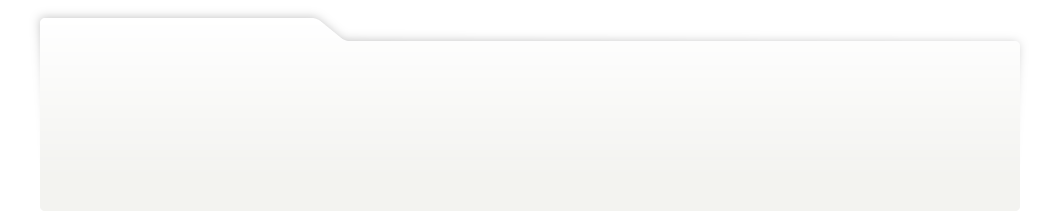
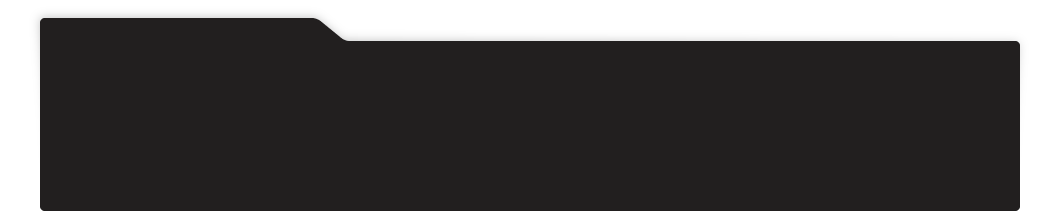
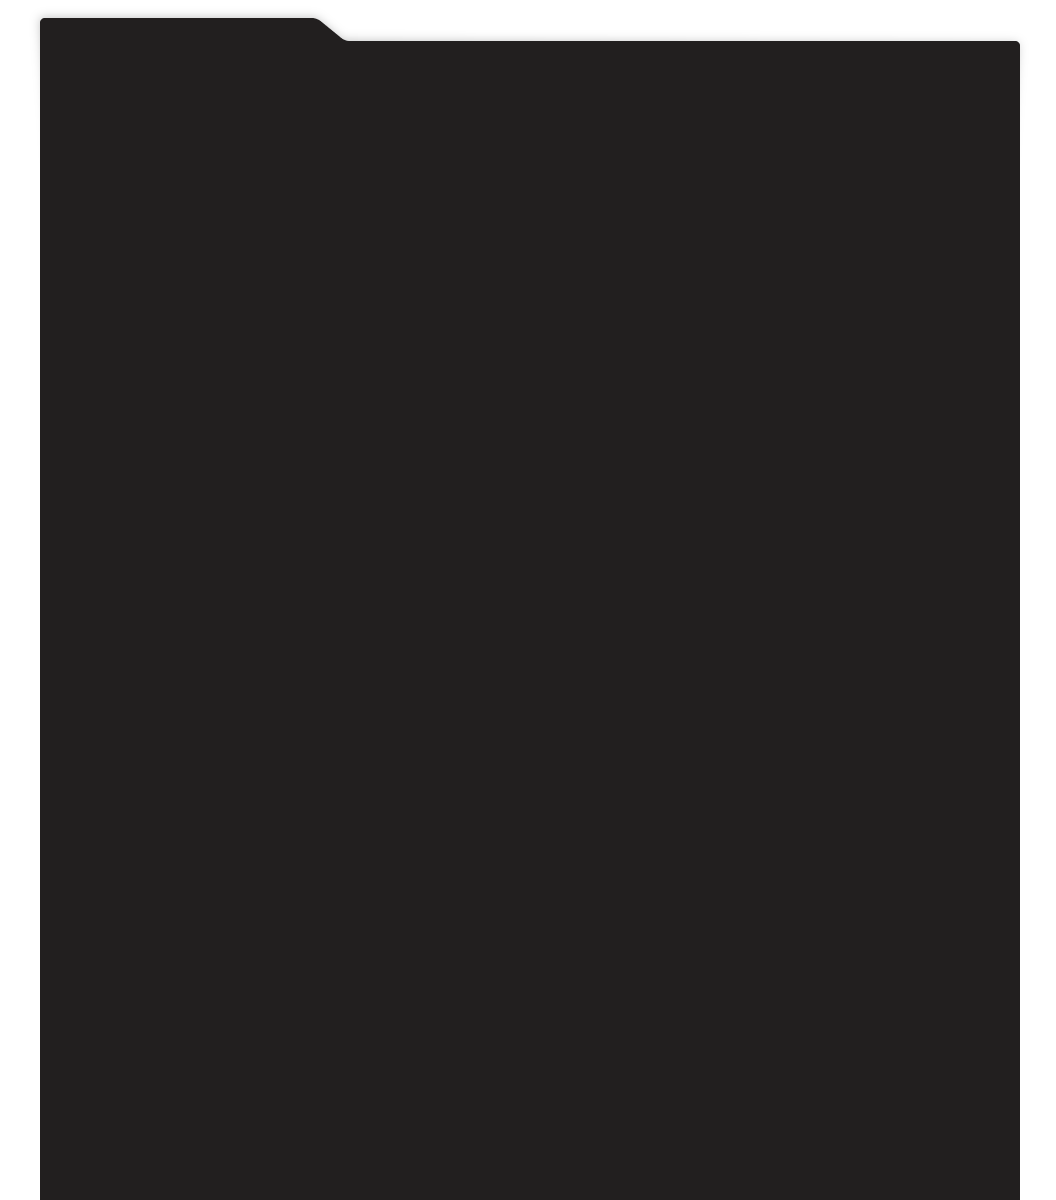
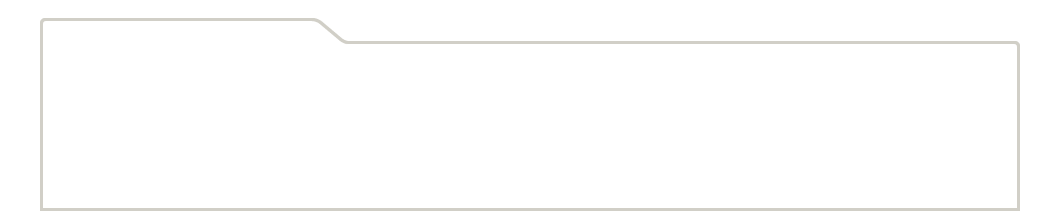
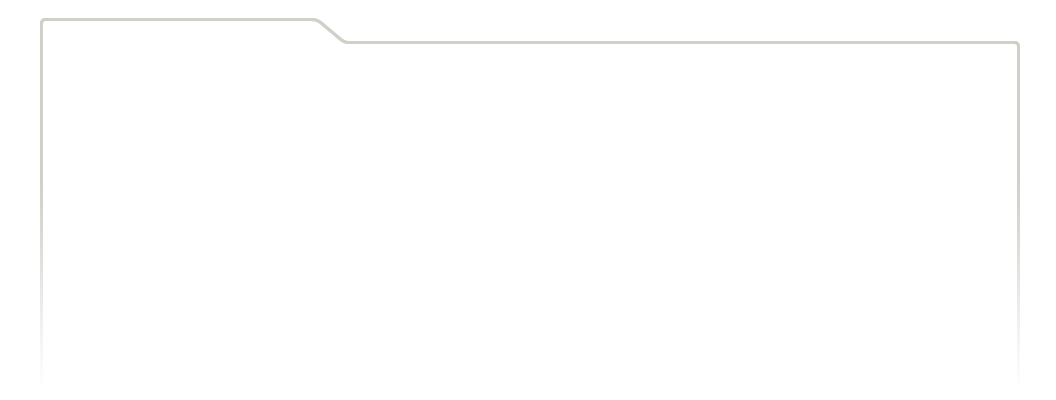
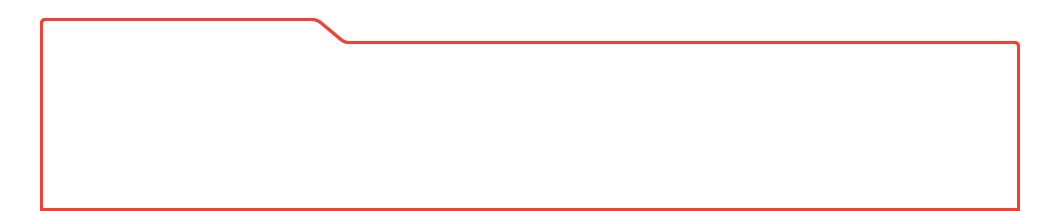
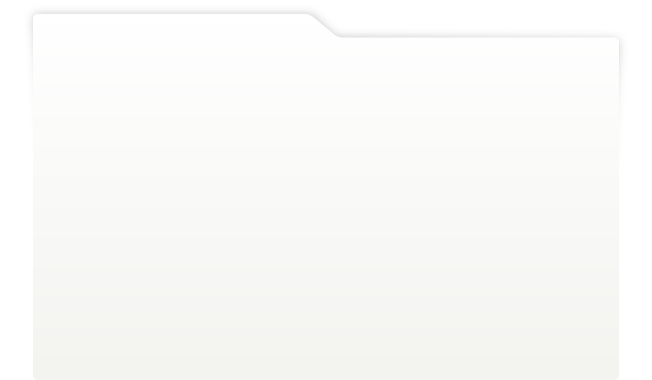
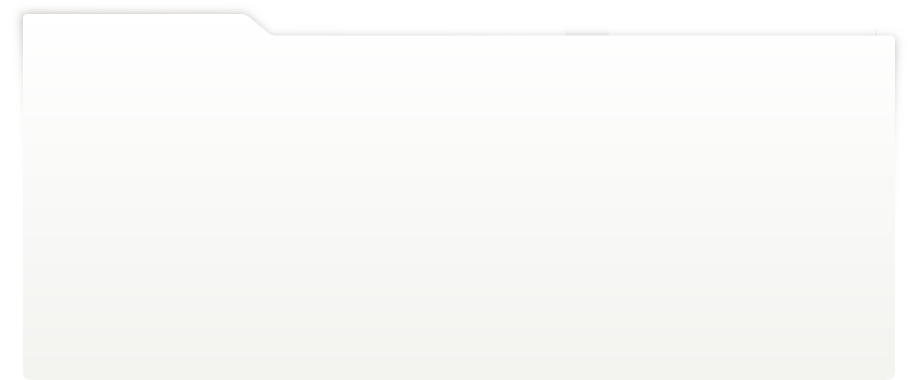
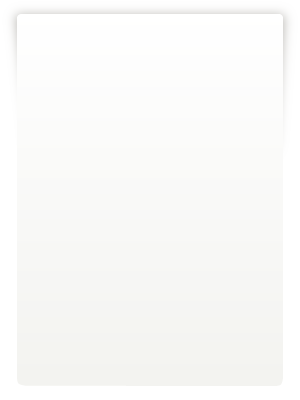
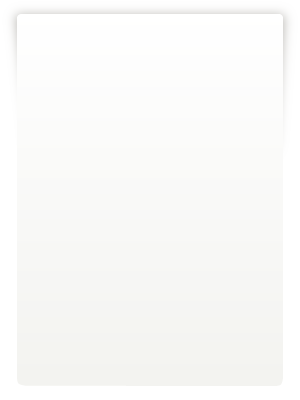
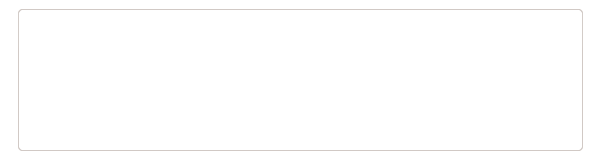
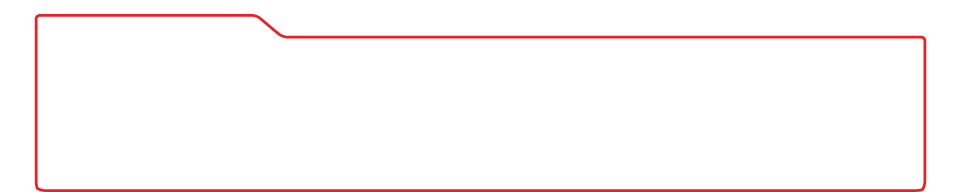
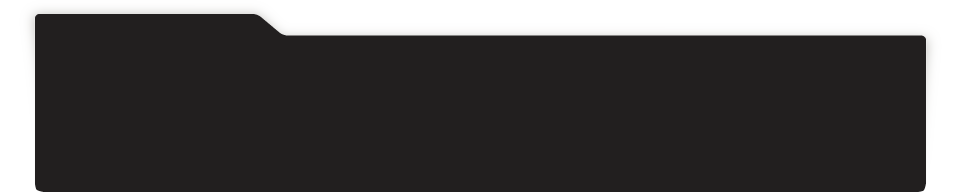
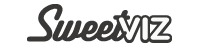
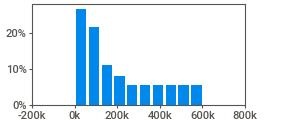
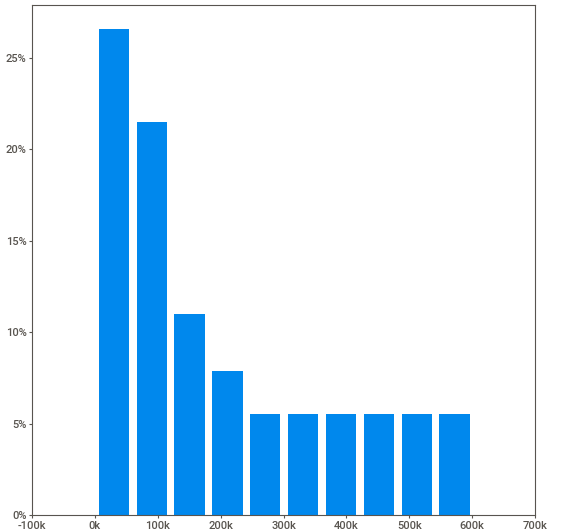
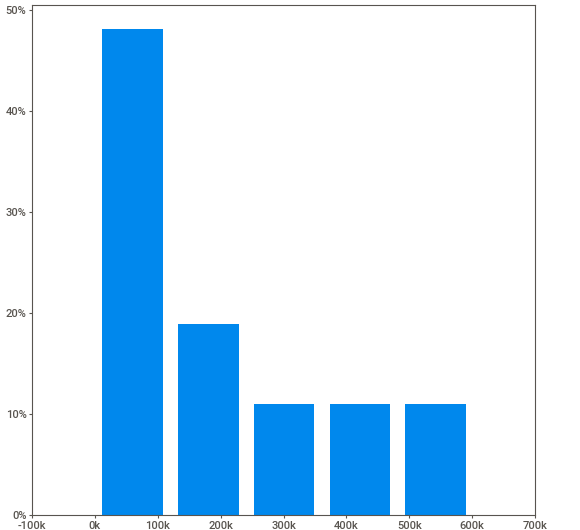
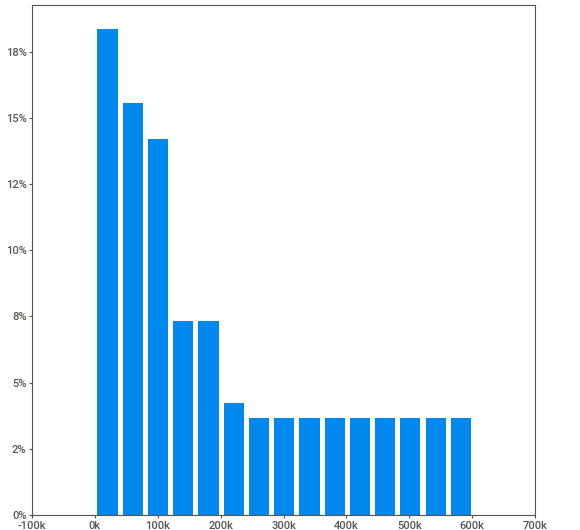
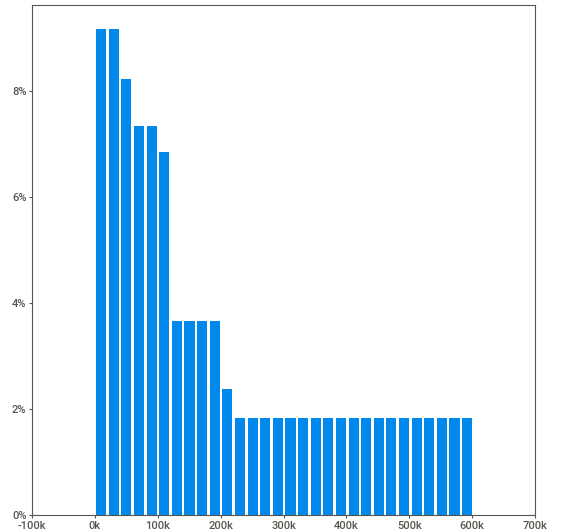
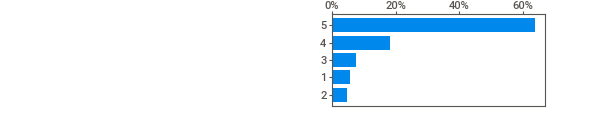
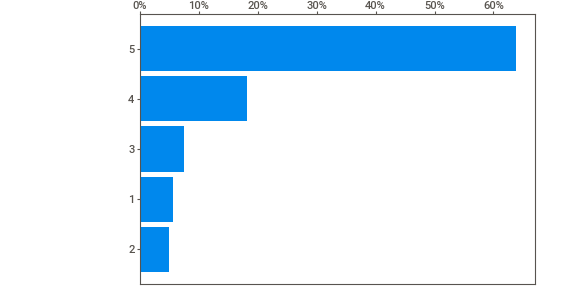
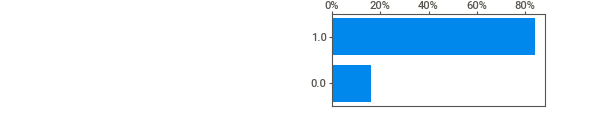
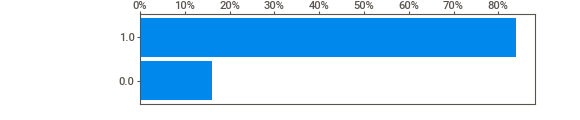
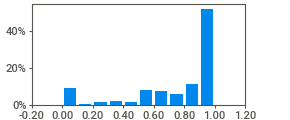
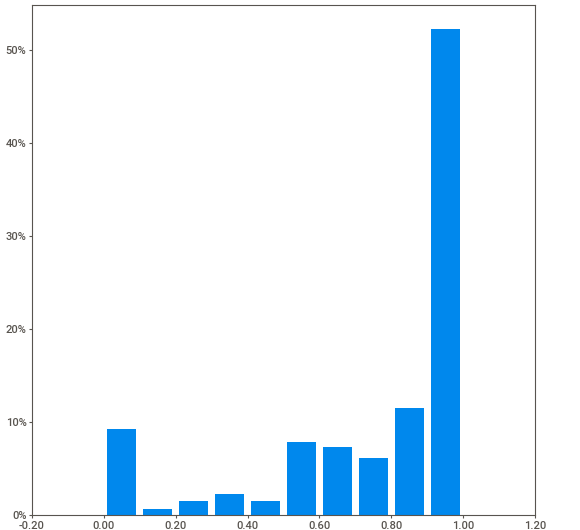
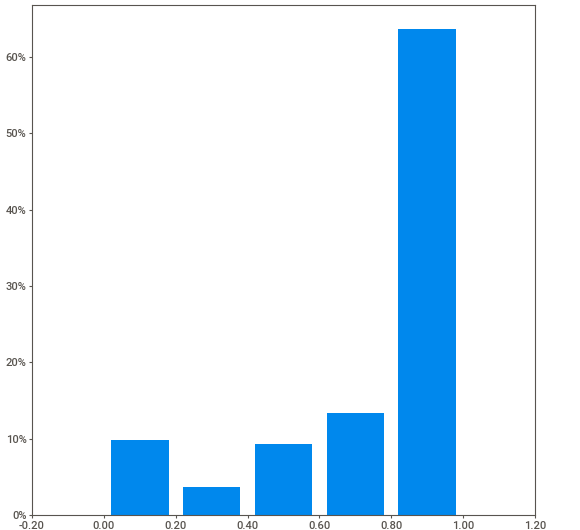
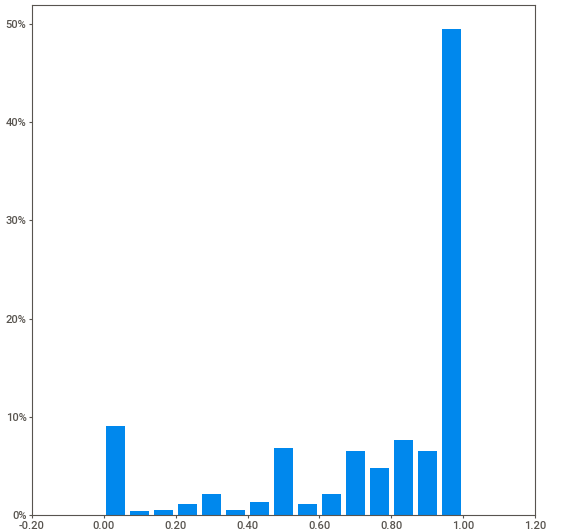
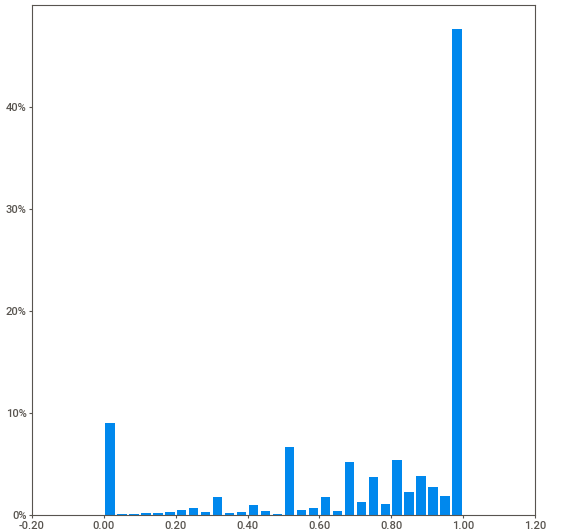
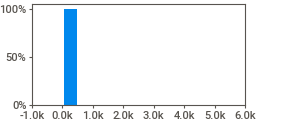
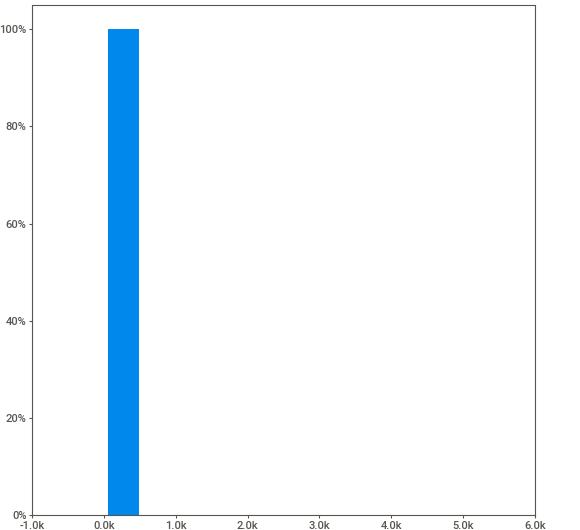
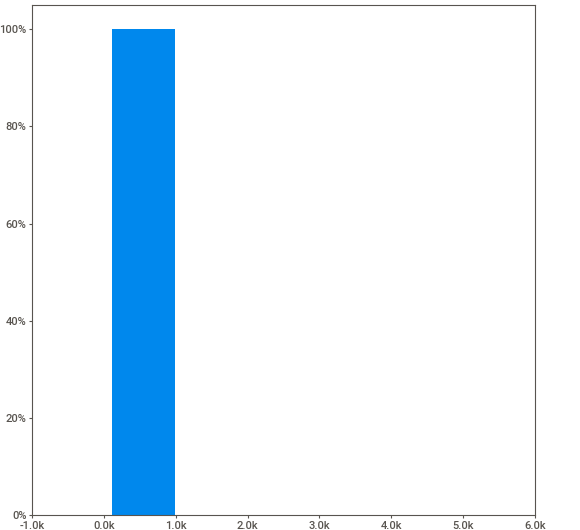
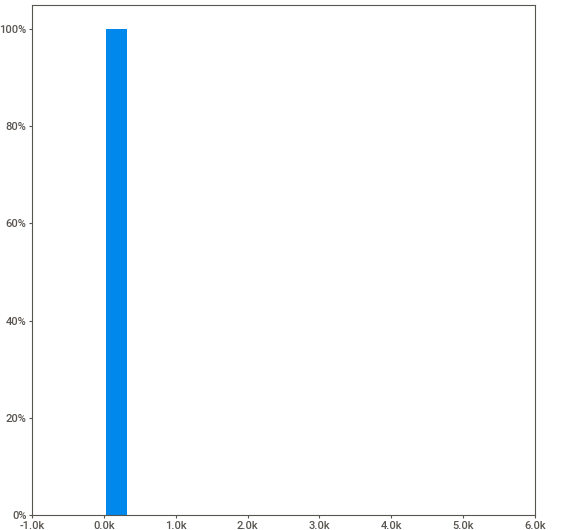
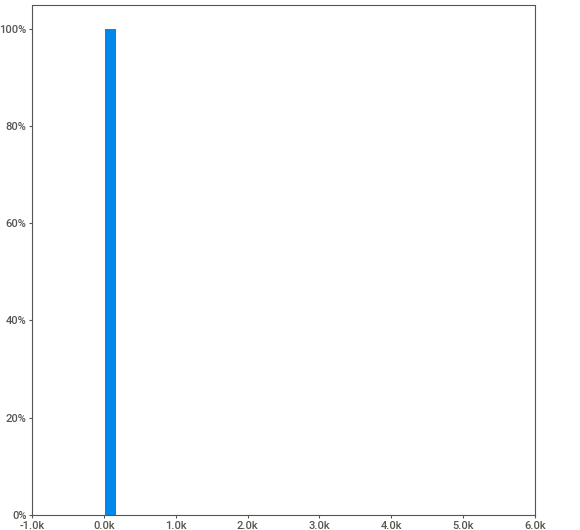
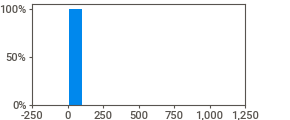
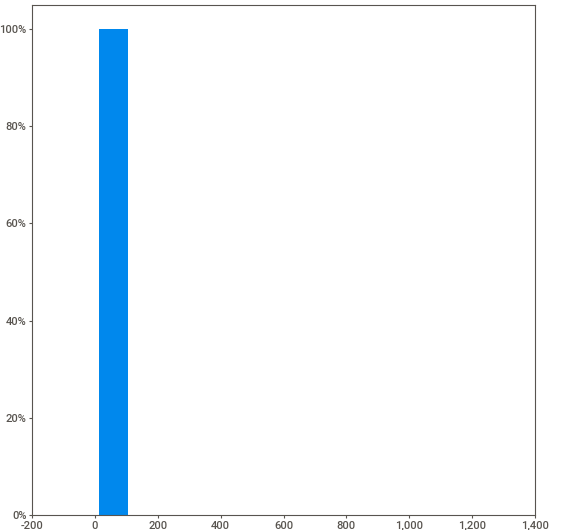
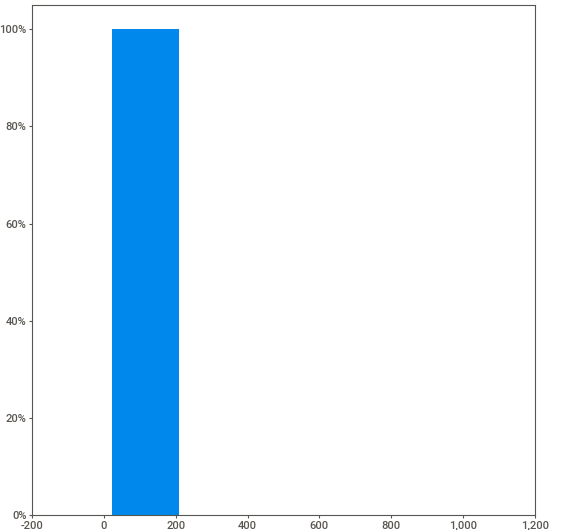
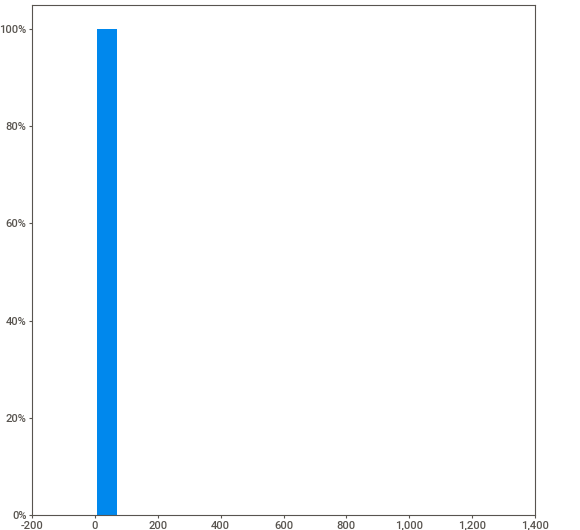
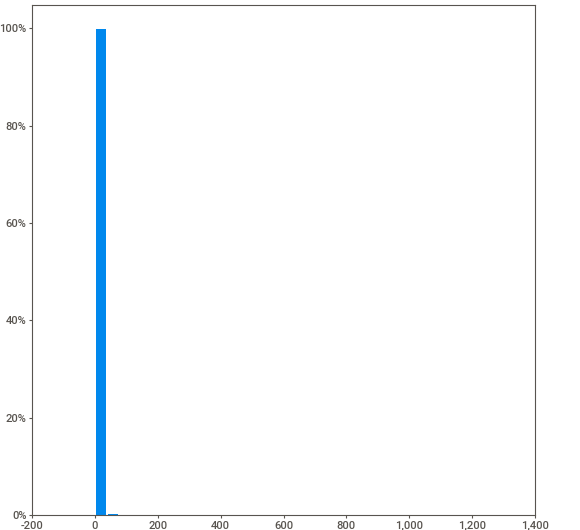
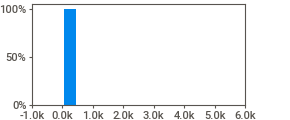
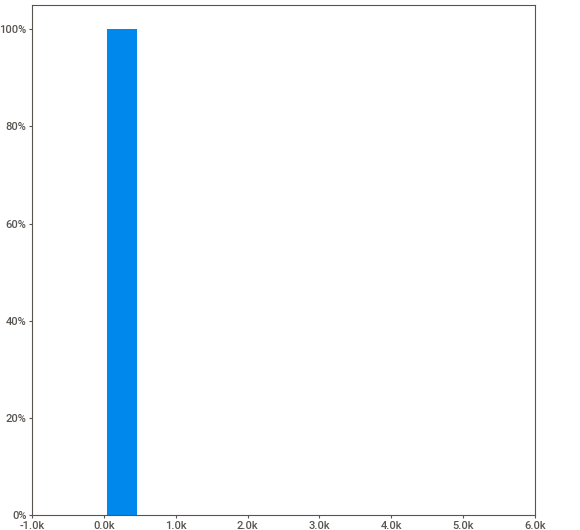
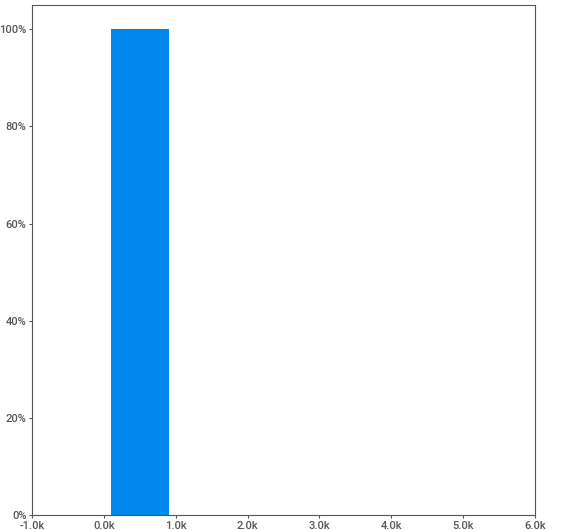
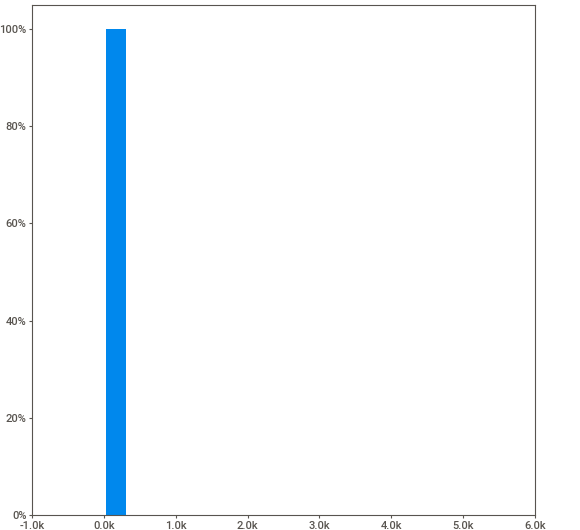
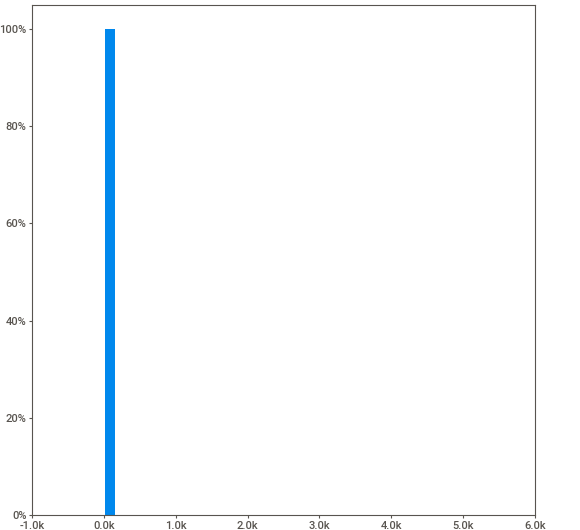
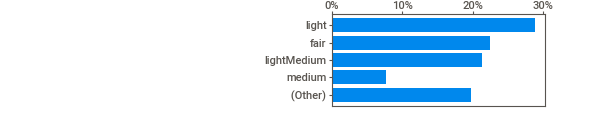
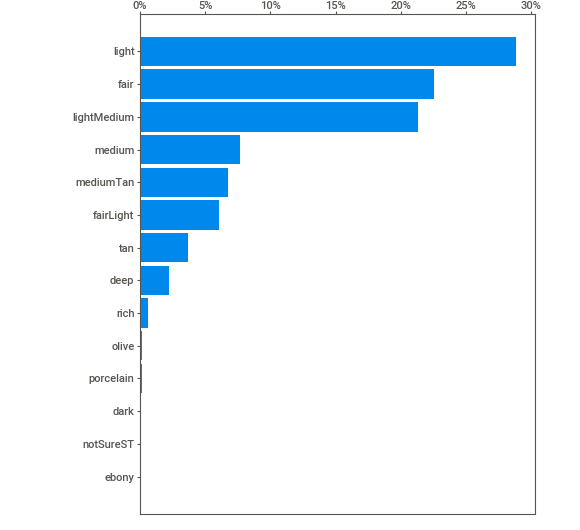
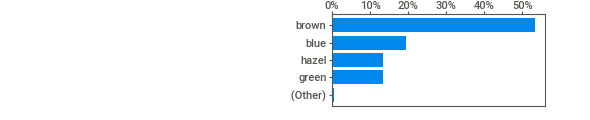
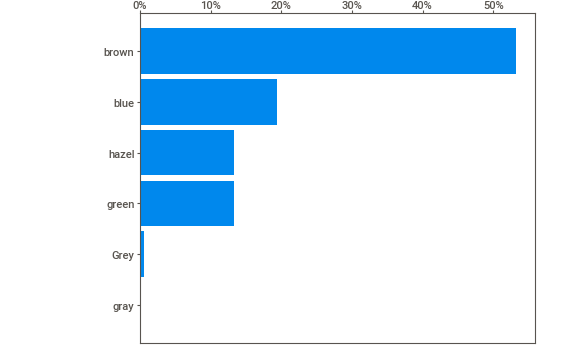
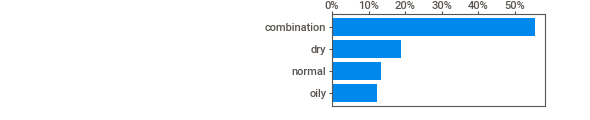
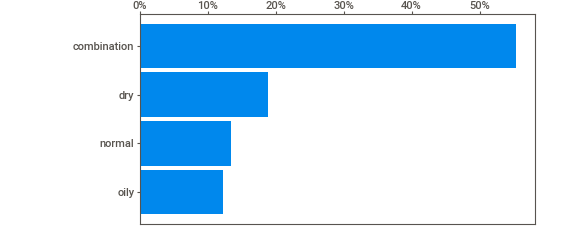
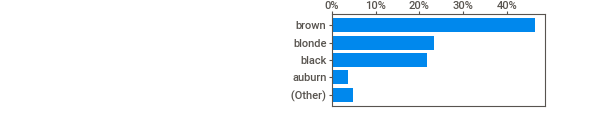
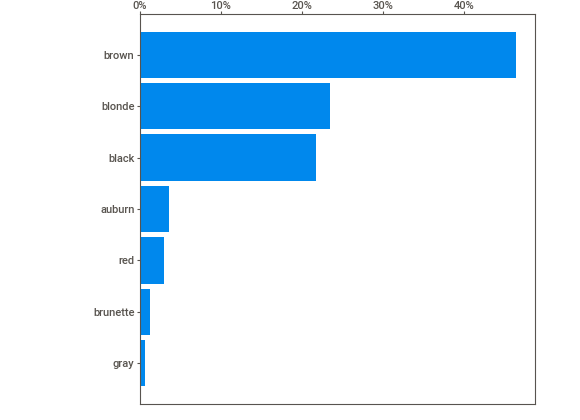
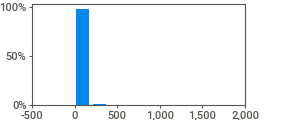
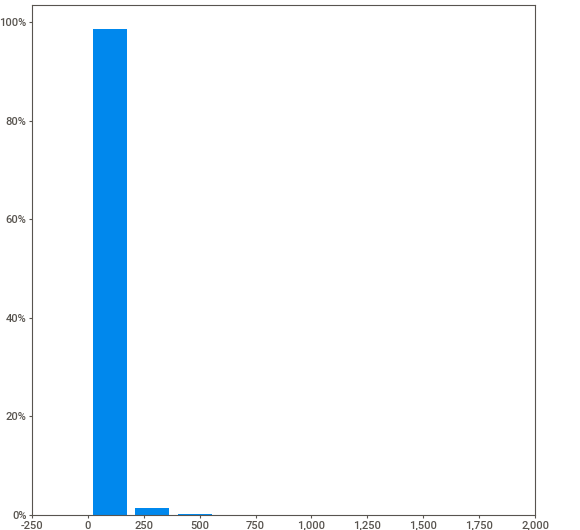
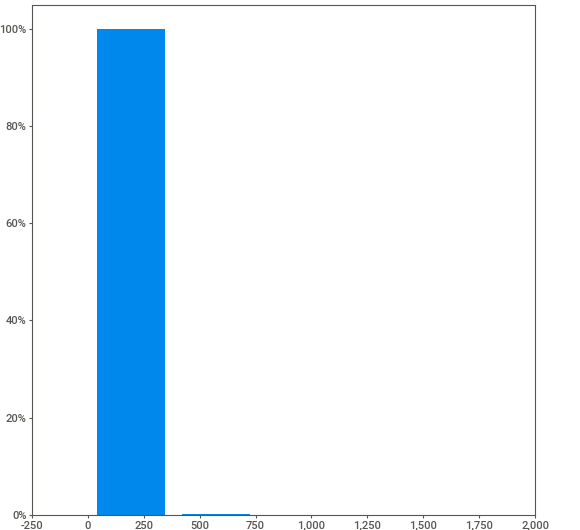
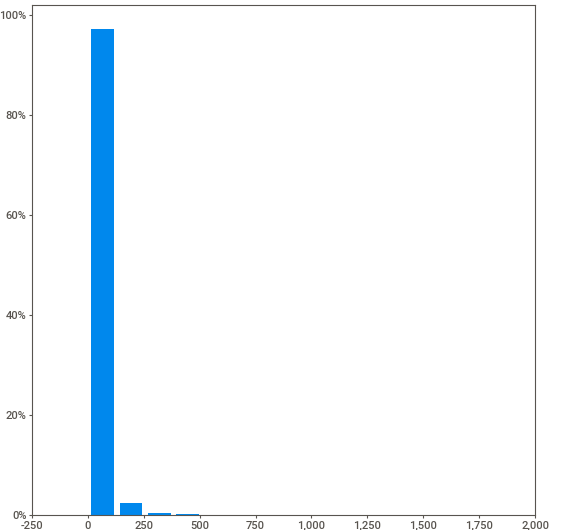
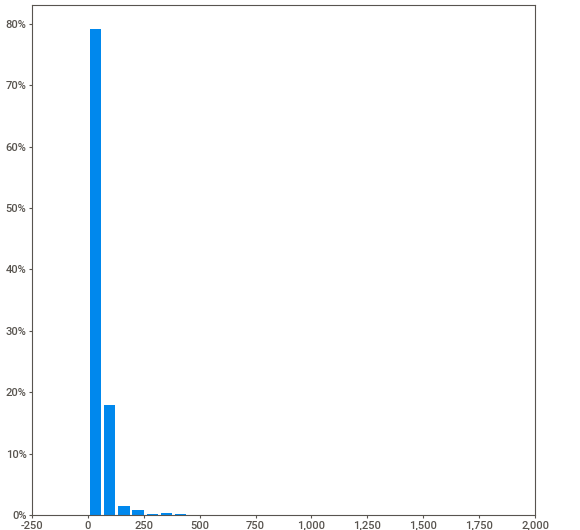
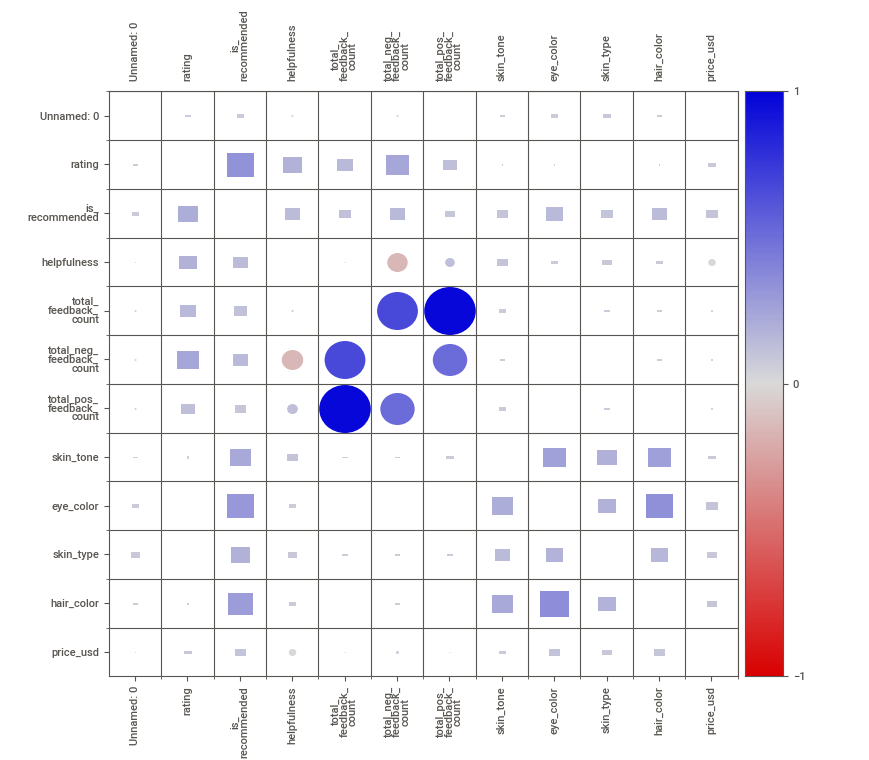
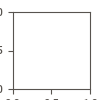

In [13]:
report.show_notebook()

<Axes: xlabel='is_recommended', ylabel='product_name'>

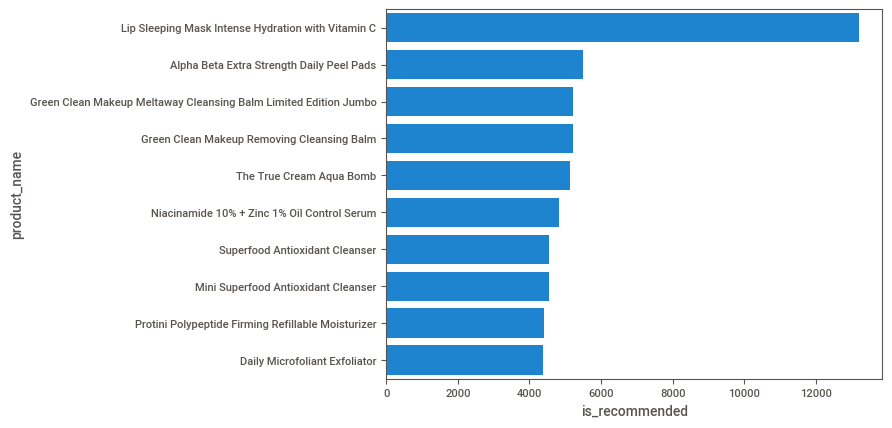

In [14]:
#Find the top 10 most reccommeded products
most_reccomended = combined_file.groupby(['product_id','product_name','brand_name']).sum(numeric_only=True)['is_recommended'].reset_index()\
.sort_values('is_recommended',ascending=False).head(10)
sns.barplot(most_reccomended,x='is_recommended',y='product_name')



In [15]:
#Get frequency of skin type
combined_file['skin_type'].value_counts()

combination    544513
dry            185937
normal         131910
oily           120494
Name: skin_type, dtype: int64

In [16]:
#Drop records with any missing values
combined_file = combined_file.dropna(how='any')

In [17]:
#Checking rating distribution after removing NAs, we can see 5 star ratings are still significantly higher.
count = combined_file['rating'].value_counts()
print (count)

5    175419
4     40911
1     30699
3     26050
2     21643
Name: rating, dtype: int64


In [18]:
#Reduce each class by sampling to the length of the minority class
df_2 = combined_file[combined_file['rating'] == 2]
df_1 = combined_file[combined_file['rating'] == 1].sample(len(df_2))
df_3 = combined_file[combined_file['rating'] == 3].sample(len(df_2))
df_4 = combined_file[combined_file['rating'] == 4].sample(len(df_2))
df_5 = combined_file[combined_file['rating'] == 5].sample(len(df_2))


In [19]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5], axis = 0)
df = shuffle(df)
df.head()

Unnamed: 0    author_id  rating  is_recommended  helpfulness  \
536086      536086   1588616222       5             1.0     0.800000   
15610        15610   1354192275       1             0.0     0.164557   
92055        92055   5097373357       1             0.0     1.000000   
370889      370889  34676889680       5             1.0     1.000000   
181222      181222   5104976726       4             1.0     1.000000   

        total_feedback_count  total_neg_feedback_count  \
536086                     5                         1   
15610                     79                        66   
92055                      1                         0   
370889                     6                         0   
181222                     1                         0   

        total_pos_feedback_count submission_time  \
536086                         4      2019-12-15   
15610                         13      2021-05-12   
92055                          1      2021-12-17   
370889                         6      2023-02-11   
181222                         1      2022-01-20   

                                              review_text  \
536086  I’ve waited years- literally years -to try thi...   
15610   Intensive “hydrating“ cream ???!!!  Probably o...   
92055   This product doesn’t work for me. I don’t reco...   
370889  This product was on my wishlist for so long an...   
181222  On my combination, black head prone, skin usin...   

                                  review_title    skin_tone eye_color  \
536086  It’s a yaaaas for me! Thank you LaMer!        light     green   
15610                                 TERRIBLE    fairLight     brown   
92055                             don’t bother  lightMedium     hazel   
370889              Might be a holy grail item         fair     brown   
181222                       Balance & nourish          tan     brown   

          skin_type hair_color product_id  \
536086          dry      brown    P416341   
15610           dry     blonde    P384780   
92055   combination      brown    P467655   
370889          dry      black    P466123   
181222  combination      brown    P477830   

                                         product_name           brand_name  \
536086                    Crème de la Mer Moisturizer               La Mer   
15610   Pure Argan Milk Intensive Hydrating Treatment          Josie Maran   
92055                    Succinic Acid Acne Treatment       The INKEY List   
370889          Watermelon Glow Niacinamide Dew Drops          Glow Recipe   
181222                Superberry Dream Cleansing Balm  Youth To The People   

        price_usd  
536086     380.00  
15610       56.00  
92055        9.99  
370889      35.00  
181222      39.00

In [20]:
#Using VADER to get sentiment scores for review_text
sid = SentimentIntensityAnalyzer()
df['Sentiment Scores'] = df['review_text'].apply(lambda skincare_overview: sid.polarity_scores(str(skincare_overview)))

In [21]:
df['compound'] = df['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
df.head(n=10)


Unnamed: 0    author_id  rating  is_recommended  helpfulness  \
536086      536086   1588616222       5             1.0     0.800000   
15610        15610   1354192275       1             0.0     0.164557   
92055        92055   5097373357       1             0.0     1.000000   
370889      370889  34676889680       5             1.0     1.000000   
181222      181222   5104976726       4             1.0     1.000000   
12074        12074   2148851539       3             0.0     1.000000   
13318        13318    948516920       4             1.0     0.592593   
74031        74031   8708244014       2             0.0     0.800000   
571861      571861   6413022536       1             0.0     0.333333   
20113        20113   5349912614       3             0.0     0.666667   

        total_feedback_count  total_neg_feedback_count  \
536086                     5                         1   
15610                     79                        66   
92055                      1                         0   
370889                     6                         0   
181222                     1                         0   
12074                     18                         0   
13318                     27                        11   
74031                      5                         1   
571861                     3                         2   
20113                      3                         1   

        total_pos_feedback_count submission_time  \
536086                         4      2019-12-15   
15610                         13      2021-05-12   
92055                          1      2021-12-17   
370889                         6      2023-02-11   
181222                         1      2022-01-20   
12074                         18      2020-08-09   
13318                         16      2019-03-03   
74031                          4      2020-05-02   
571861                         1      2019-06-18   
20113                          2      2019-04-28   

                                              review_text  ... eye_color  \
536086  I’ve waited years- literally years -to try thi...  ...     green   
15610   Intensive “hydrating“ cream ???!!!  Probably o...  ...     brown   
92055   This product doesn’t work for me. I don’t reco...  ...     hazel   
370889  This product was on my wishlist for so long an...  ...     brown   
181222  On my combination, black head prone, skin usin...  ...     brown   
12074   I’ve been using this product for about 2-3 mon...  ...     green   
13318   Just received the whole POTENT C VITAMIN LINE....  ...     brown   
74031   pros: this does NOT bother my sensitive eyes. ...  ...      blue   
571861  I wanted to like this. I love Ren stuff, but t...  ...     brown   
20113   Loved the original moisturizer but this makes ...  ...     green   

          skin_type hair_color product_id  \
536086          dry      brown    P416341   
15610           dry     blonde    P384780   
92055   combination      brown    P467655   
370889          dry      black    P466123   
181222  combination      brown    P477830   
12074   combination     auburn    P475135   
13318          oily     auburn    P440317   
74031   combination      black    P453226   
571861  combination        red    P428095   
20113   combination      brown    P422004   

                                           product_name           brand_name  \
536086                      Crème de la Mer Moisturizer               La Mer   
15610     Pure Argan Milk Intensive Hydrating Treatment          Josie Maran   
92055                      Succinic Acid Acne Treatment       The INKEY List   
370889            Watermelon Glow Niacinamide Dew Drops          Glow Recipe   
181222                  Superberry Dream Cleansing Balm  Youth To The People   
12074         Mini Vitamin C Glycolic Brightening Serum                Murad   
13318     Potent-C Vitamin C Bright & Plump Moisturizer    Peter Thomas Roth   
74031   Bright-Eyed 100% Miner

In [22]:
#Using VADER to get sentiment scores for review_title
df['Sentiment Scores 2'] = df['review_title'].apply(lambda skincare_overview2: sid.polarity_scores(str(skincare_overview2)))

df['compound2'] = df['Sentiment Scores 2'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type2']=''
df.loc[df.compound2>0,'sentiment_type2']='POSITIVE'
df.loc[df.compound2==0,'sentiment_type2']='NEUTRAL'
df.loc[df.compound2<0,'sentiment_type2']='NEGATIVE'
df.head(n=10)


Unnamed: 0    author_id  rating  is_recommended  helpfulness  \
536086      536086   1588616222       5             1.0     0.800000   
15610        15610   1354192275       1             0.0     0.164557   
92055        92055   5097373357       1             0.0     1.000000   
370889      370889  34676889680       5             1.0     1.000000   
181222      181222   5104976726       4             1.0     1.000000   
12074        12074   2148851539       3             0.0     1.000000   
13318        13318    948516920       4             1.0     0.592593   
74031        74031   8708244014       2             0.0     0.800000   
571861      571861   6413022536       1             0.0     0.333333   
20113        20113   5349912614       3             0.0     0.666667   

        total_feedback_count  total_neg_feedback_count  \
536086                     5                         1   
15610                     79                        66   
92055                      1                         0   
370889                     6                         0   
181222                     1                         0   
12074                     18                         0   
13318                     27                        11   
74031                      5                         1   
571861                     3                         2   
20113                      3                         1   

        total_pos_feedback_count submission_time  \
536086                         4      2019-12-15   
15610                         13      2021-05-12   
92055                          1      2021-12-17   
370889                         6      2023-02-11   
181222                         1      2022-01-20   
12074                         18      2020-08-09   
13318                         16      2019-03-03   
74031                          4      2020-05-02   
571861                         1      2019-06-18   
20113                          2      2019-04-28   

                                              review_text  ... product_id  \
536086  I’ve waited years- literally years -to try thi...  ...    P416341   
15610   Intensive “hydrating“ cream ???!!!  Probably o...  ...    P384780   
92055   This product doesn’t work for me. I don’t reco...  ...    P467655   
370889  This product was on my wishlist for so long an...  ...    P466123   
181222  On my combination, black head prone, skin usin...  ...    P477830   
12074   I’ve been using this product for about 2-3 mon...  ...    P475135   
13318   Just received the whole POTENT C VITAMIN LINE....  ...    P440317   
74031   pros: this does NOT bother my sensitive eyes. ...  ...    P453226   
571861  I wanted to like this. I love Ren stuff, but t...  ...    P428095   
20113   Loved the original moisturizer but this makes ...  ...    P422004   

                                           product_name           brand_name  \
536086                      Crème de la Mer Moisturizer               La Mer   
15610     Pure Argan Milk Intensive Hydrating Treatment          Josie Maran   
92055                      Succinic Acid Acne Treatment       The INKEY List   
370889            Watermelon Glow Niacinamide Dew Drops          Glow Recipe   
181222                  Superberry Dream Cleansing Balm  Youth To The People   
12074         Mini Vitamin C Glycolic Brightening Serum                Murad   
13318     Potent-C Vitamin C Bright & Plump Moisturizer    Peter Thomas Roth   
74031   Bright-Eyed 100% Mineral Eye Cream SPF 40 PA+++           Supergoop!   
571861                Ready Steady Glow Daily AHA Tonic   REN Clean Skincare   
20113         Ultra Facial Moisturizer Sunscreen SPF 30   Kiehl's Since 1851   

       price_usd                                   Sentiment Scores compound  \
536086    380.00  {'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...   0.9658   
15610      56.00  {'neg': 0.231, 'neu': 0.681, 'pos': 0.088, 'co...  -0.8742   
92055       9.99  {'neg': 0.0, 'ne

In [23]:
df = df.drop(columns=['Sentiment Scores', 'Sentiment Scores 2'], axis=1)

                                             |          | [  0%]   00:00 -> (? left)


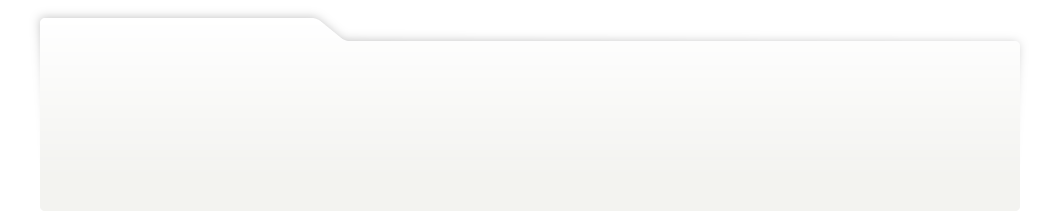
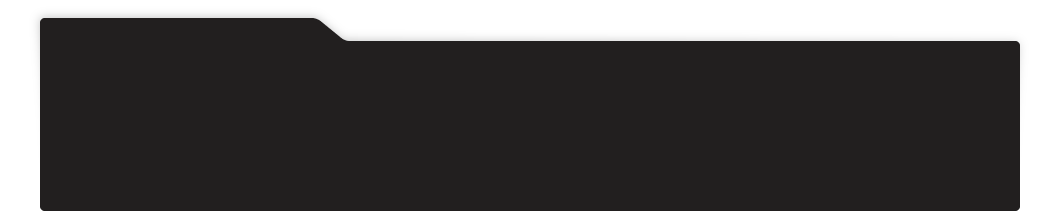
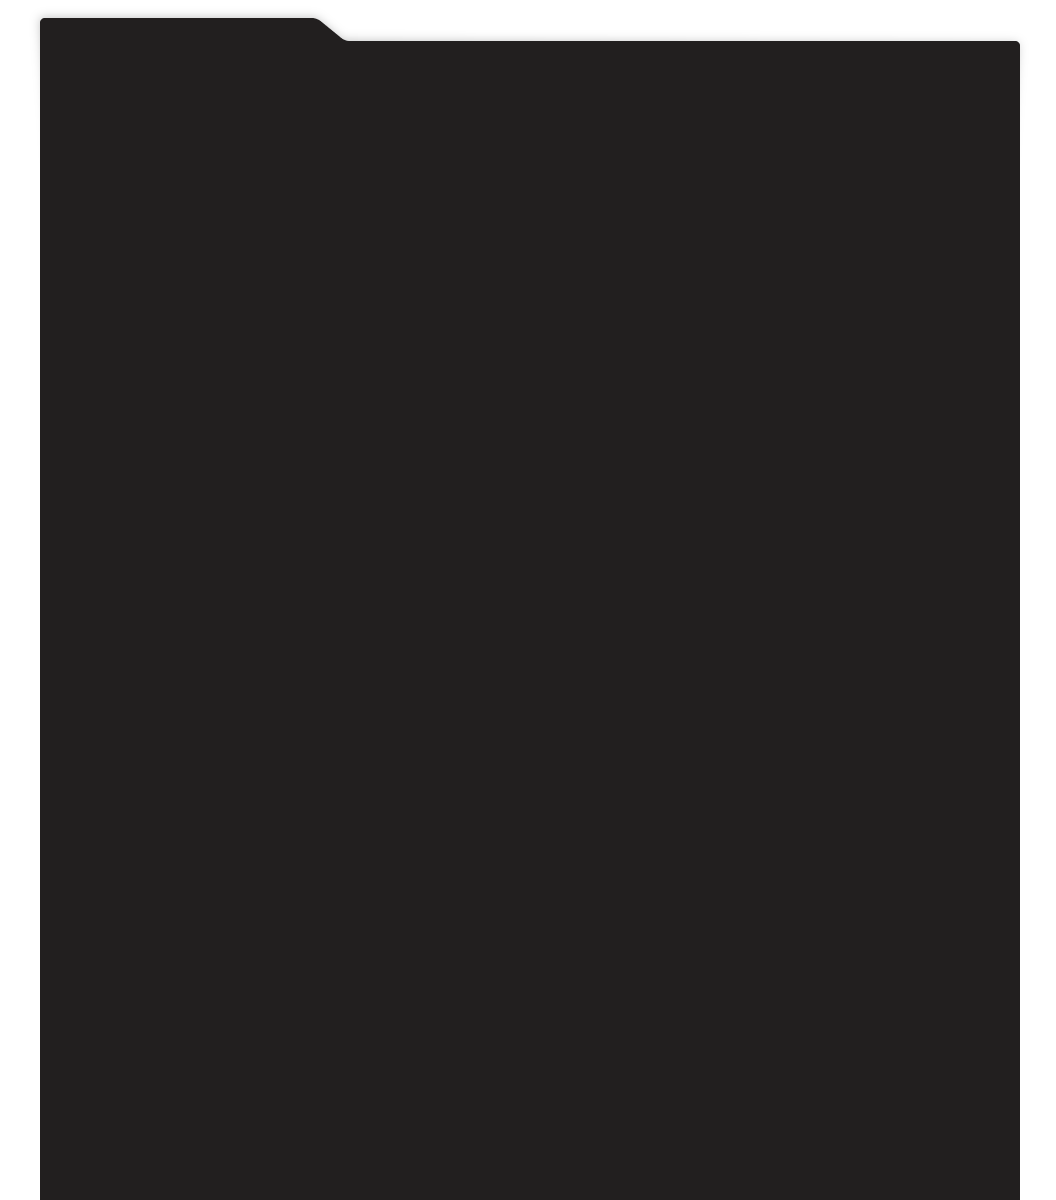
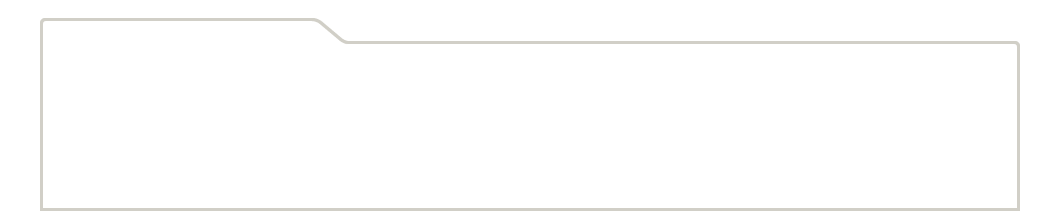
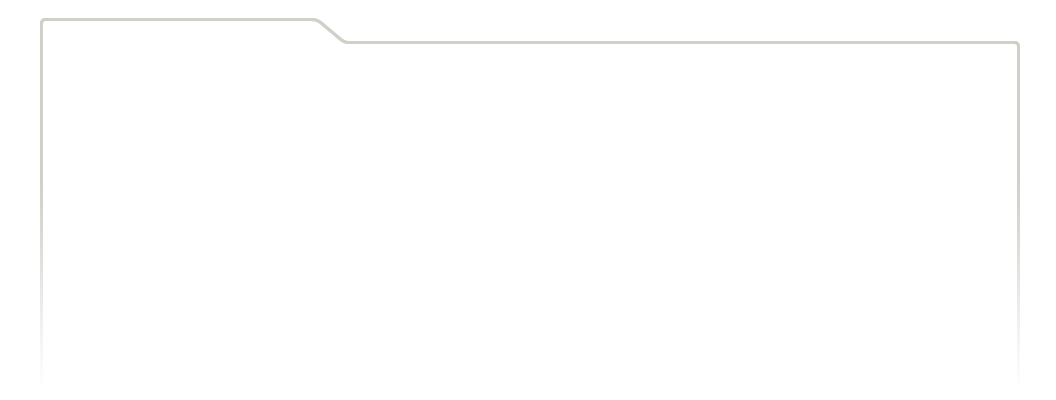
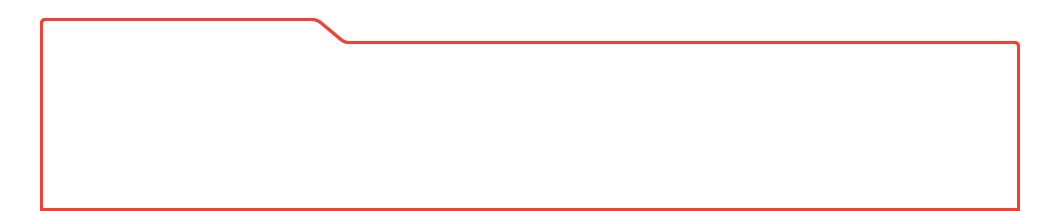
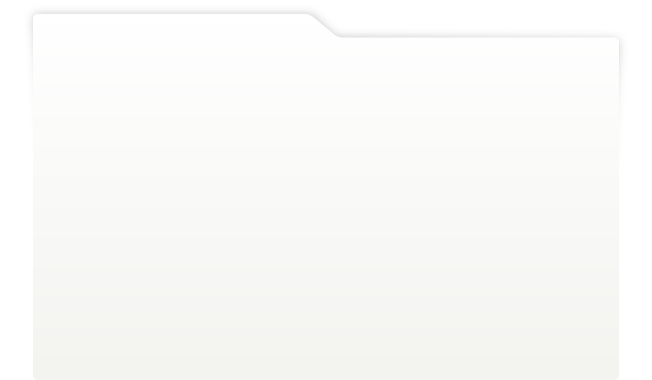
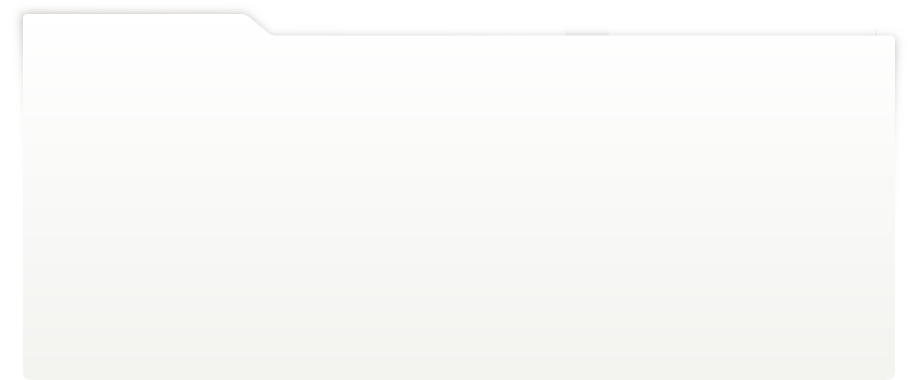
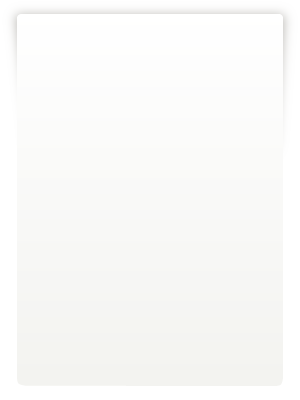
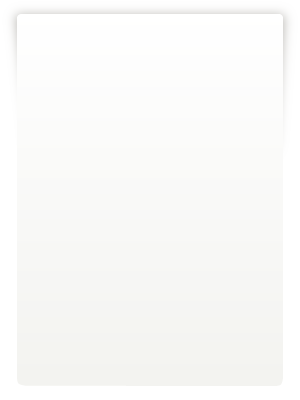
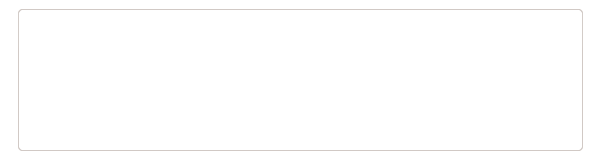
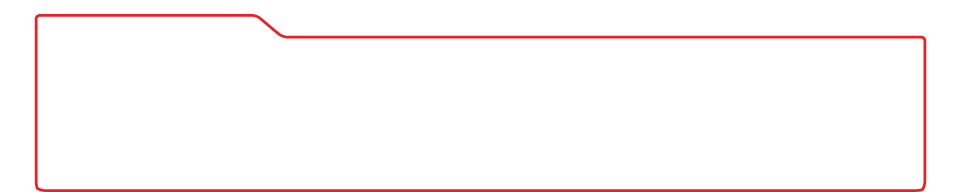
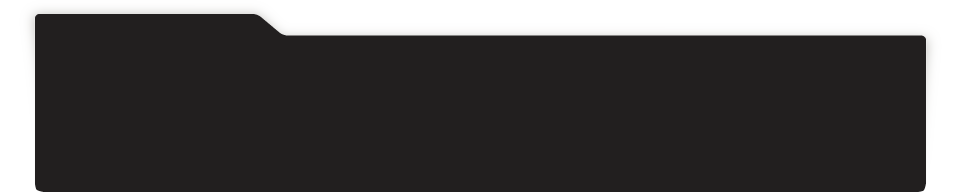
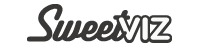
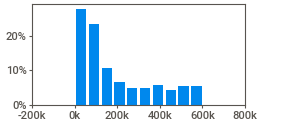
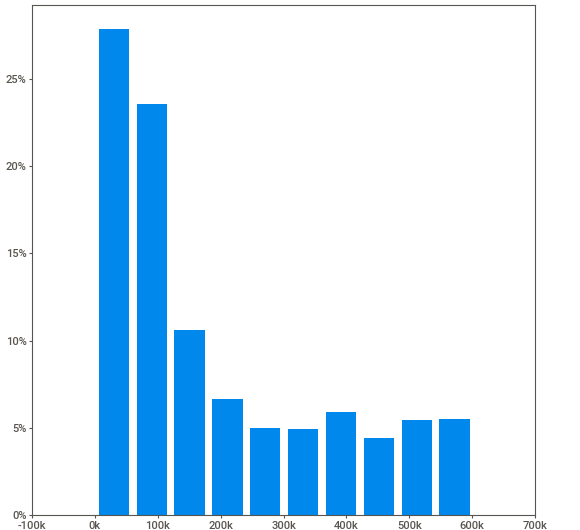
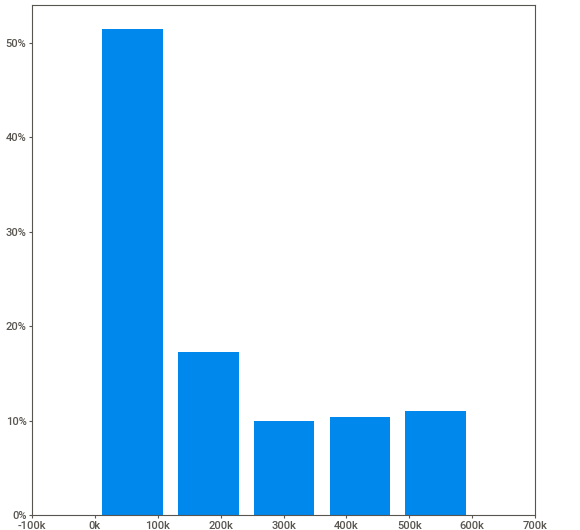
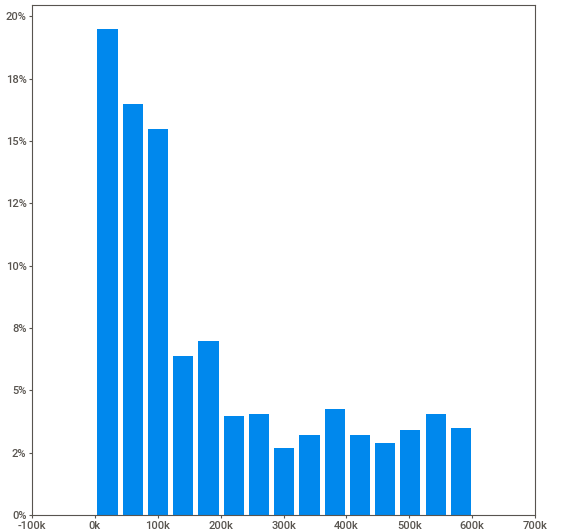
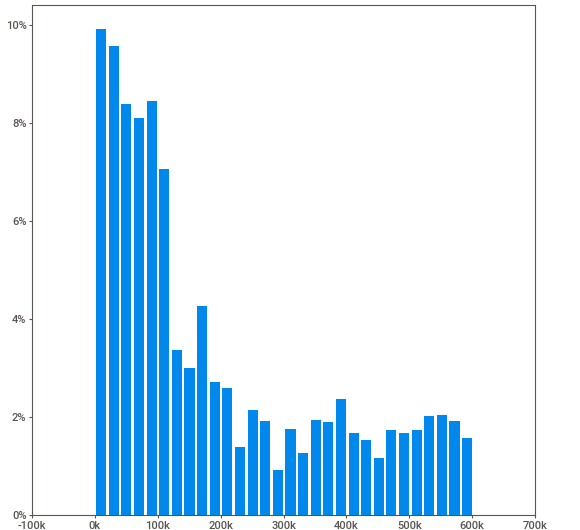
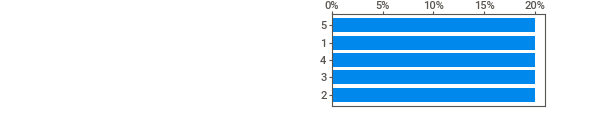
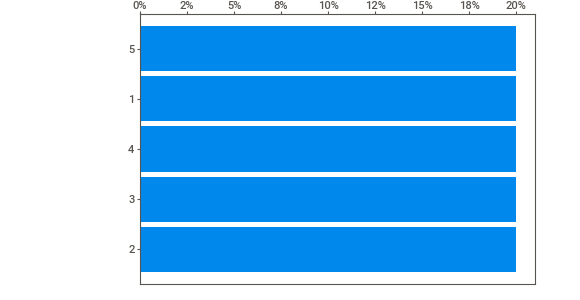
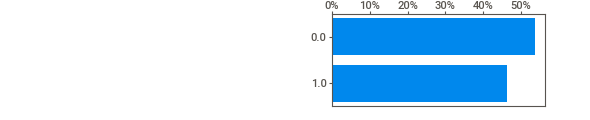
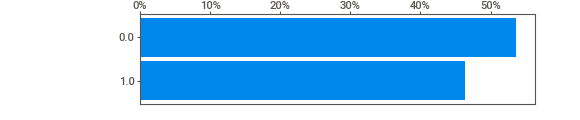
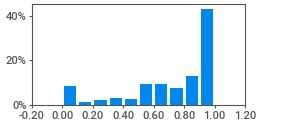
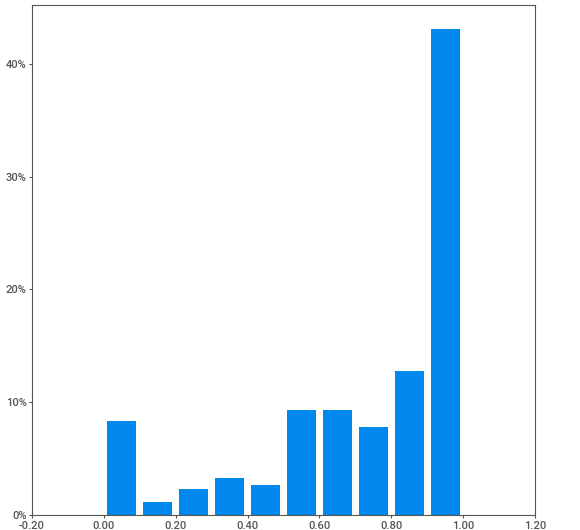
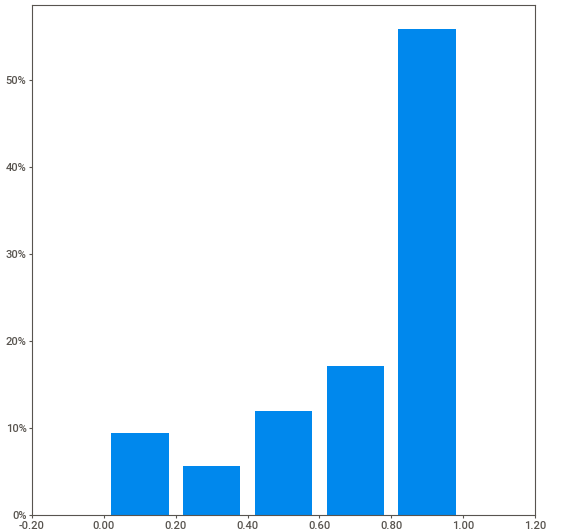
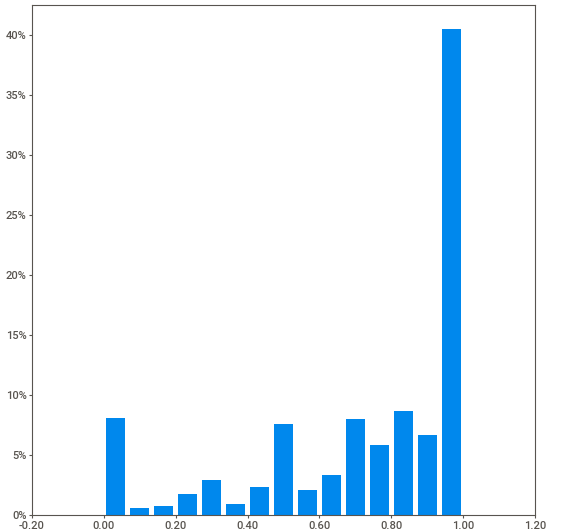
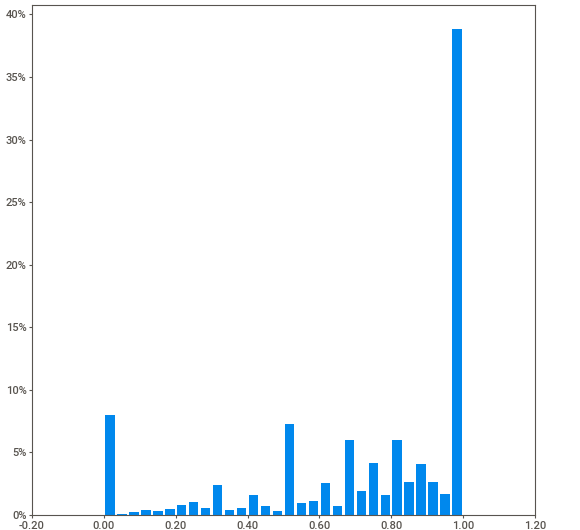
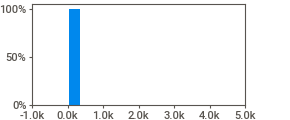
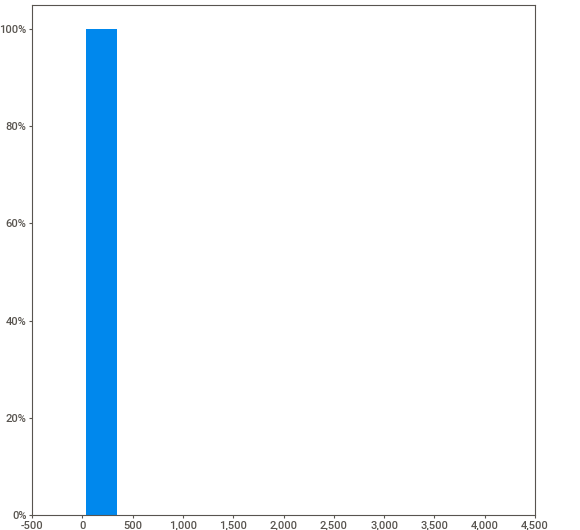
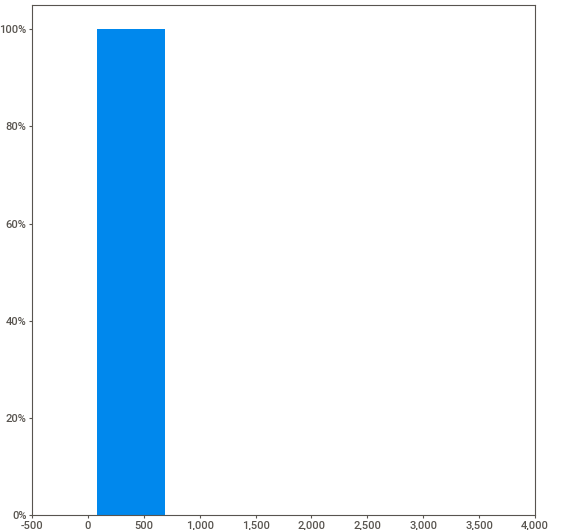
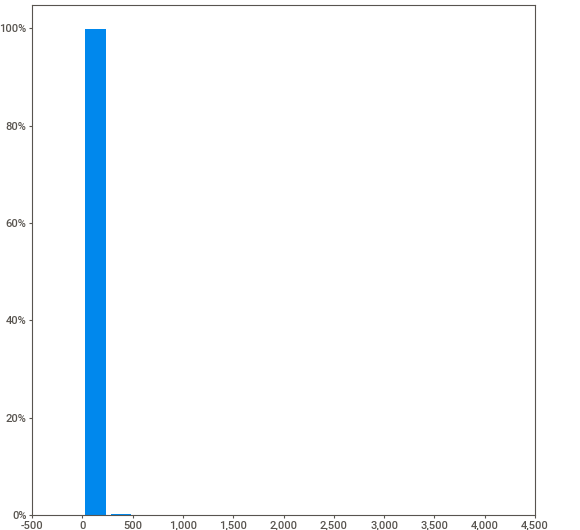
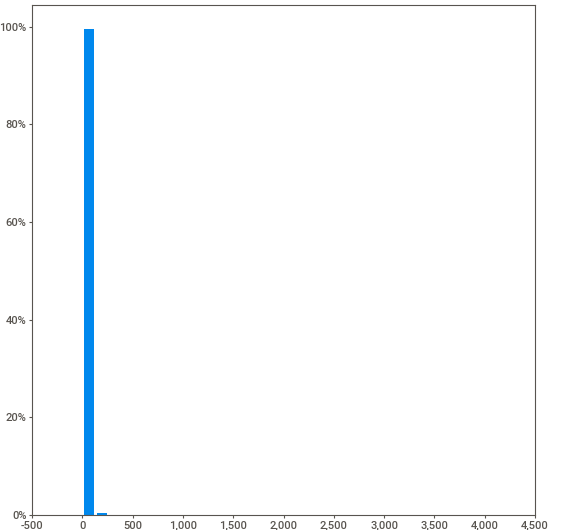
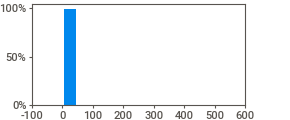
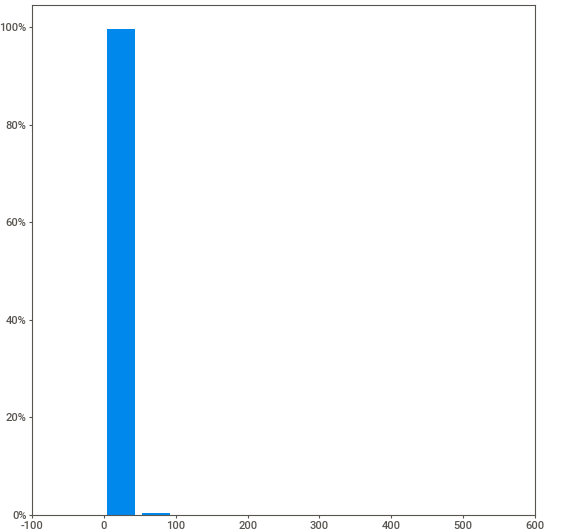
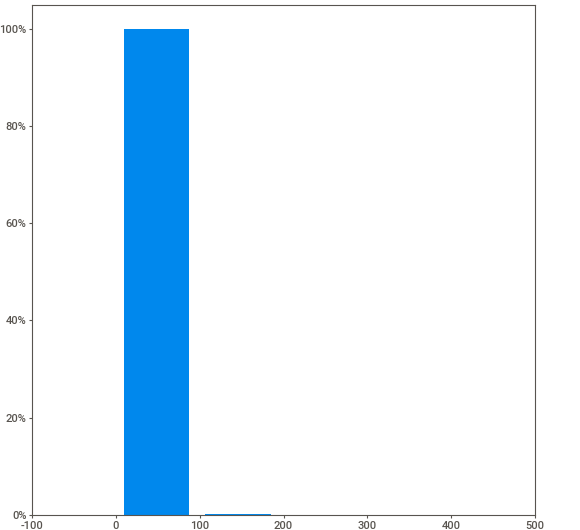
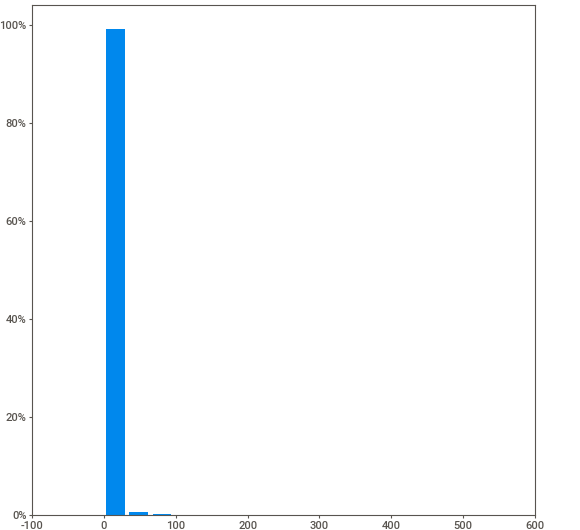
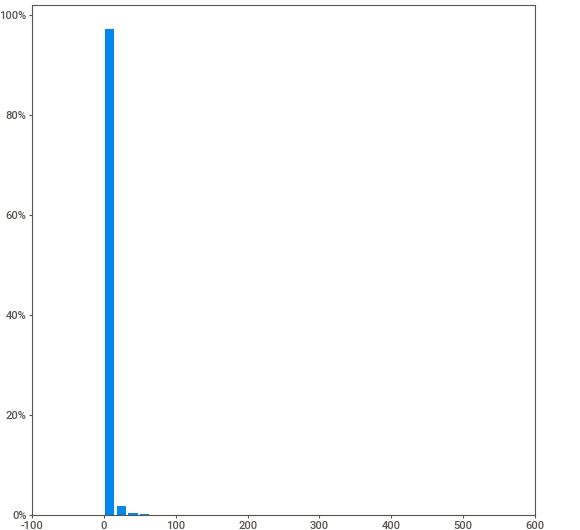
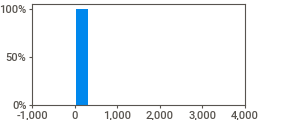
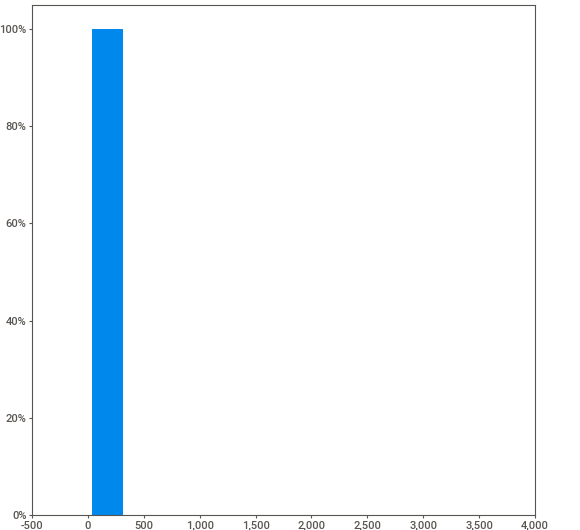
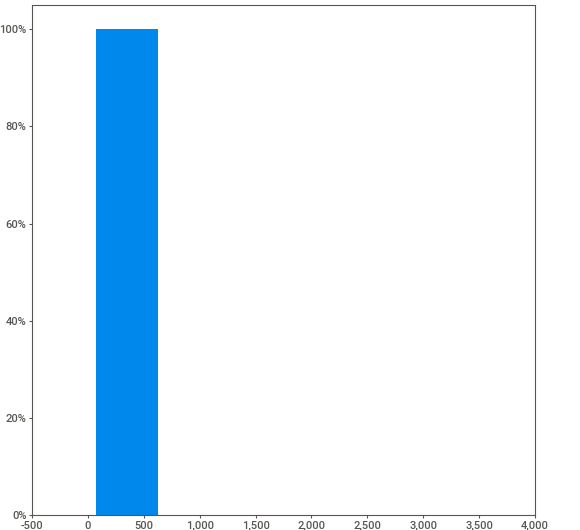
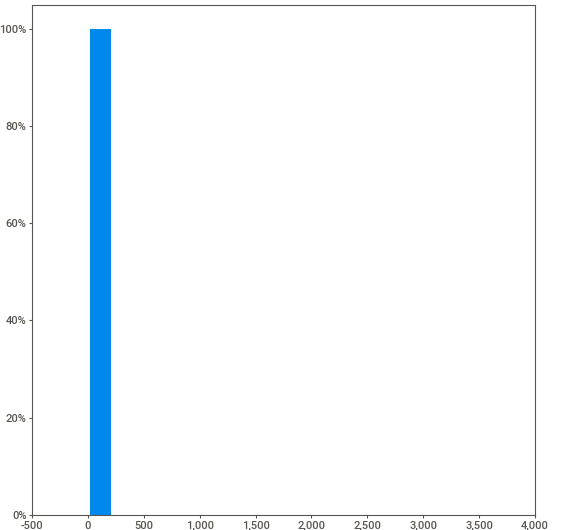
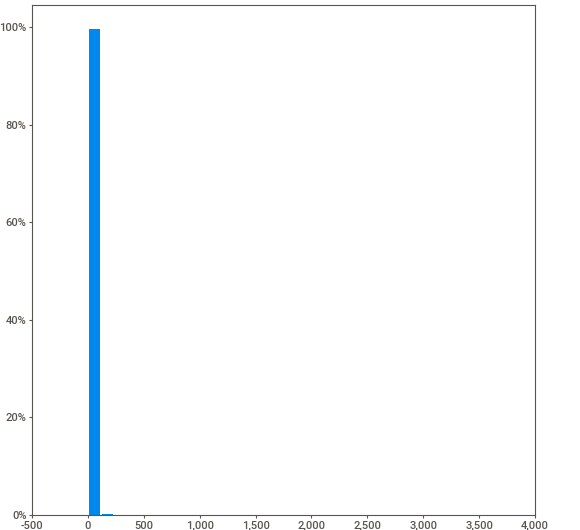
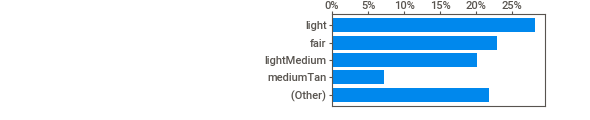
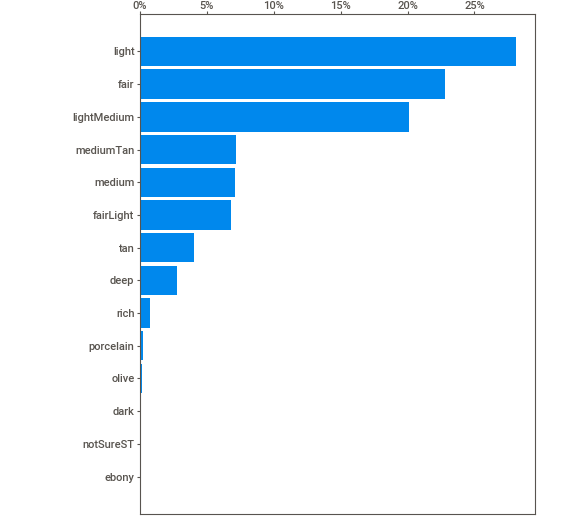
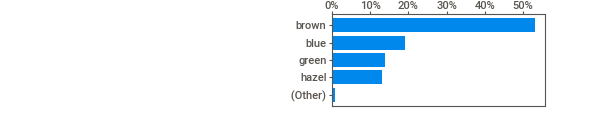
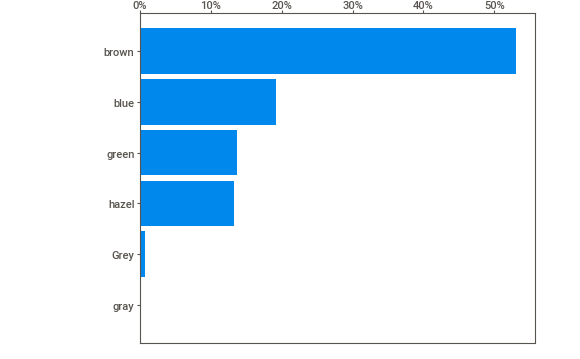
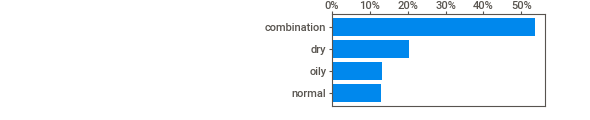
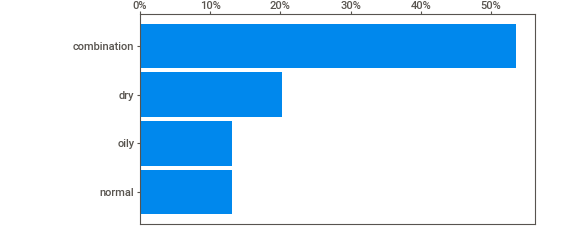
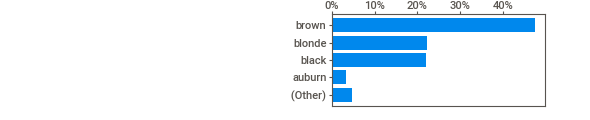
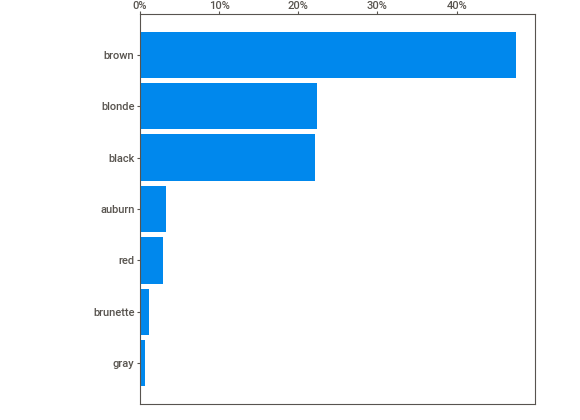
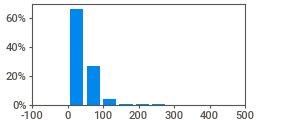
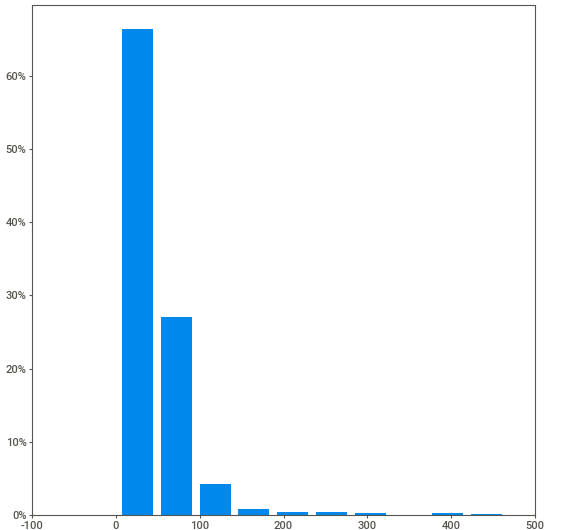
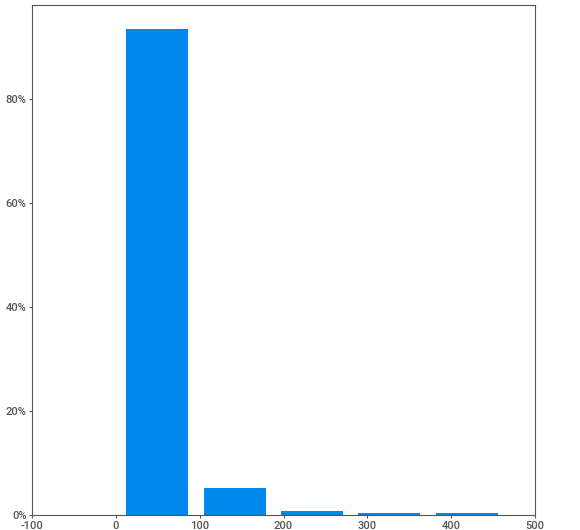
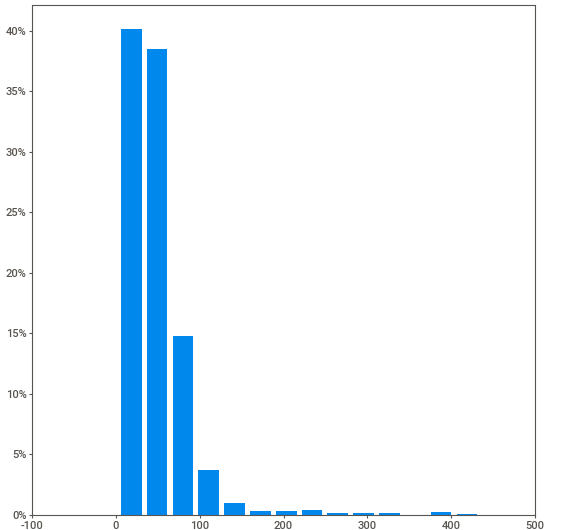
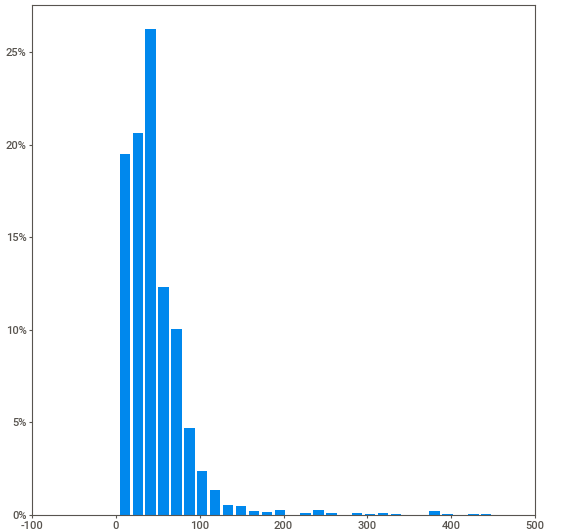
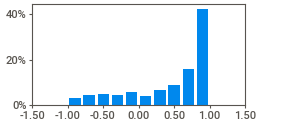
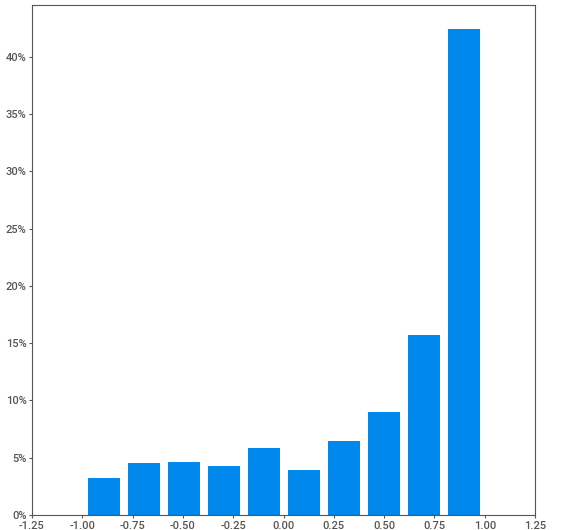
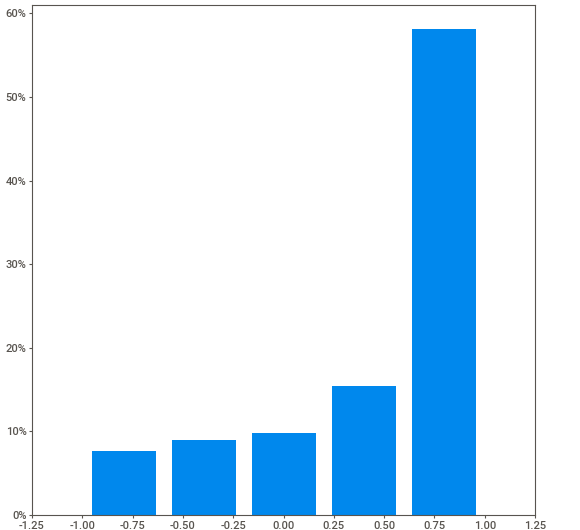
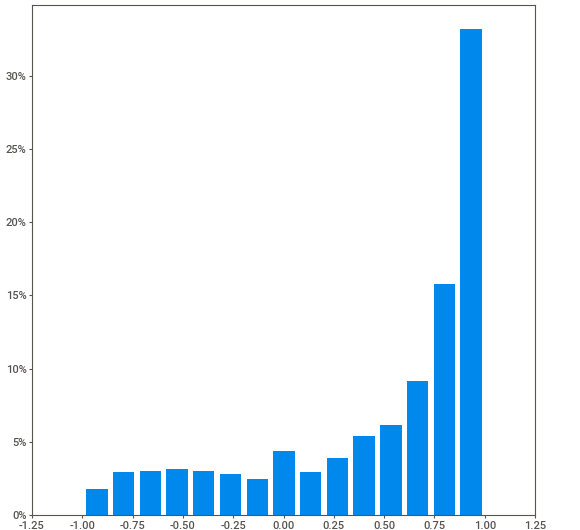
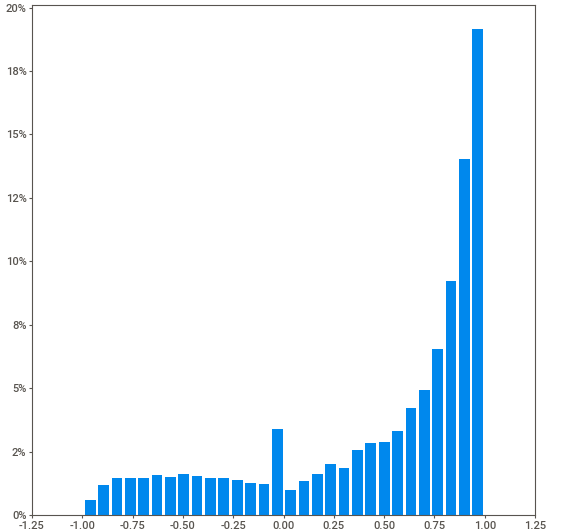
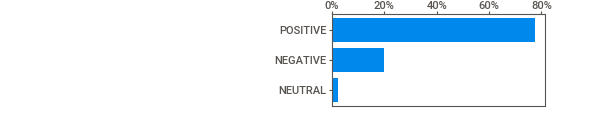
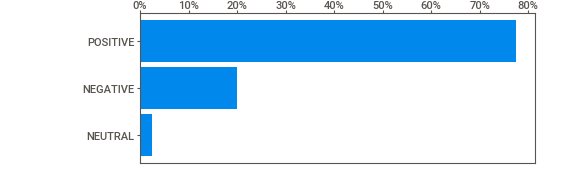
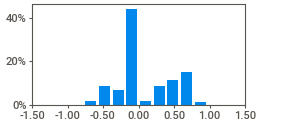
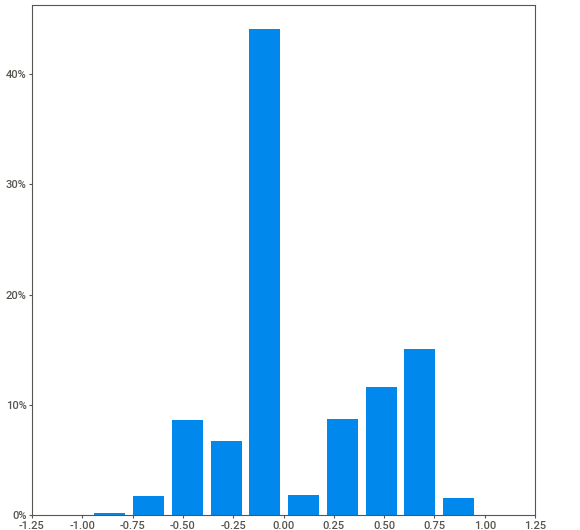
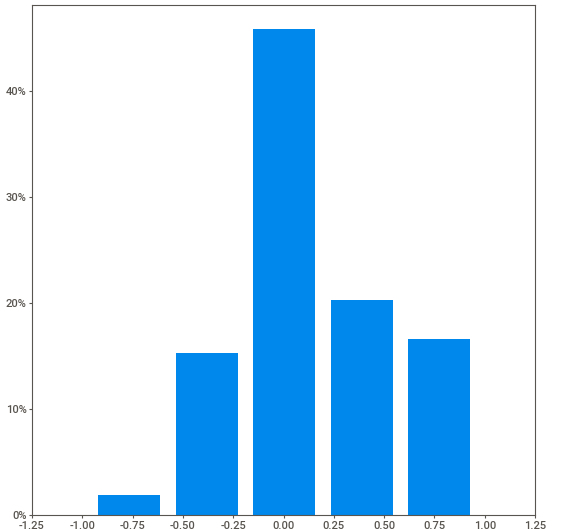
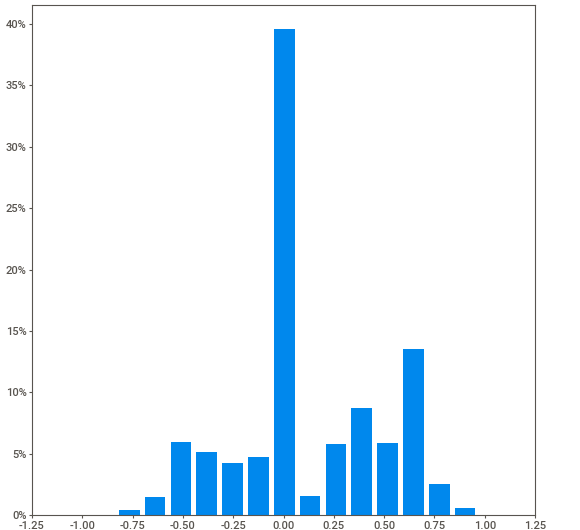
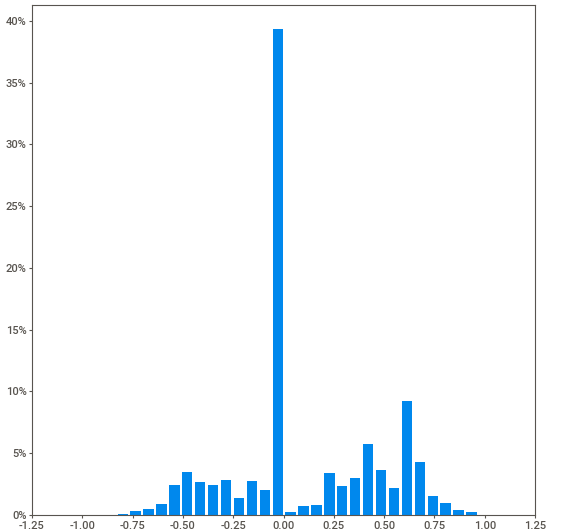
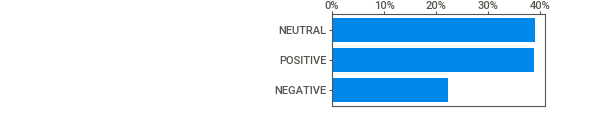
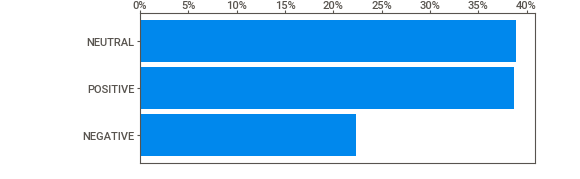
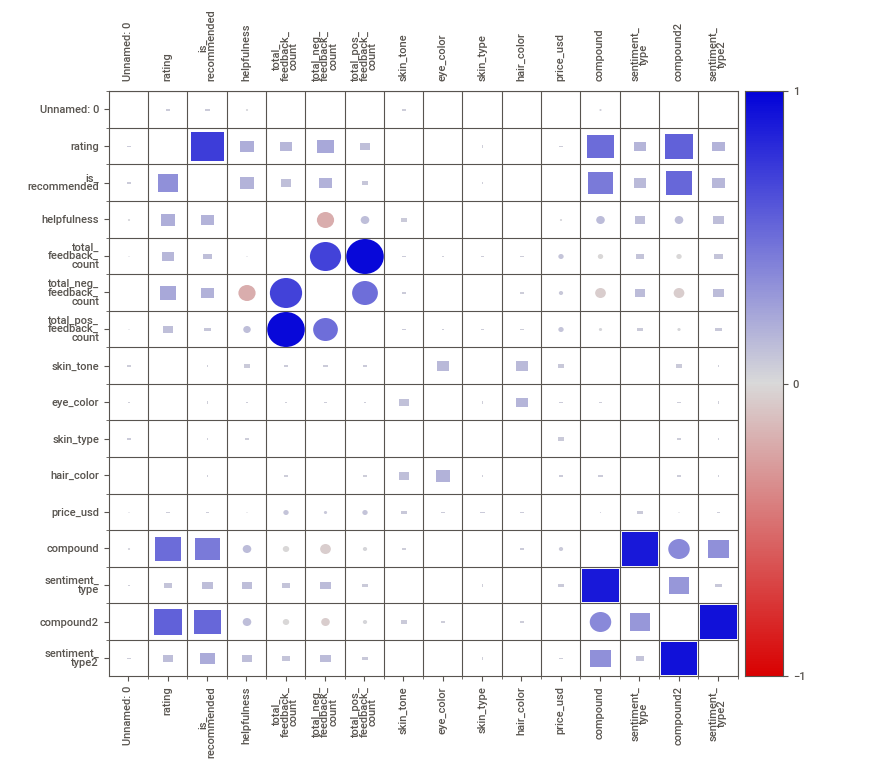
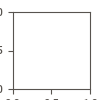

In [24]:
#Regenerate EDA report
report2 = sv.analyze(df)
report2.show_notebook()

In [25]:
df.corr(method= 'spearman')

Unnamed: 0    rating  is_recommended  helpfulness  \
Unnamed: 0                  1.000000 -0.011394       -0.013538    -0.010120   
rating                     -0.011394  1.000000        0.824658     0.222666   
is_recommended             -0.013538  0.824658        1.000000     0.192165   
helpfulness                -0.010120  0.222666        0.192165     1.000000   
total_feedback_count       -0.030762 -0.276007       -0.231849    -0.187070   
total_neg_feedback_count   -0.012506 -0.329344       -0.278108    -0.808403   
total_pos_feedback_count   -0.032938 -0.188165       -0.156188     0.152073   
price_usd                  -0.008934  0.008874       -0.000071    -0.020385   
compound                   -0.005385  0.479556        0.439556     0.131419   
compound2                  -0.007703  0.516153        0.505120     0.129940   

                          total_feedback_count  total_neg_feedback_count  \
Unnamed: 0                           -0.030762                 -0.012506   
rating                               -0.276007                 -0.329344   
is_recommended                       -0.231849                 -0.278108   
helpfulness                          -0.187070                 -0.808403   
total_feedback_count                  1.000000                  0.625323   
total_neg_feedback_count              0.625323                  1.000000   
total_pos_feedback_count              0.911573                  0.329981   
price_usd                             0.007320                  0.031179   
compound                             -0.150752                 -0.181622   
compound2                            -0.179116                 -0.195778   

                          total_pos_feedback_count  price_usd  compound  \
Unnamed: 0                               -0.032938  -0.008934 -0.005385   
rating                                   -0.188165   0.008874  0.479556   
is_recommended                           -0.156188  -0.000071  0.439556   
helpfulness                               0.152073  -0.020385  0.131419   
total_feedback_count                      0.911573   0.007320 -0.150752   
total_neg_feedback_count                  0.329981   0.031179 -0.181622   
total_pos_feedback_count                  1.000000   0.009955 -0.094098   
price_usd                                 0.009955   1.000000  0.060457   
compound                                 -0.094098   0.060457  1.000000   
compound2                                -0.125009  -0.001885  0.340874   

                          compound2  
Unnamed: 0                -0.007703  
rating                     0.516153  
is_recommended             0.505120  
helpfulness                0.129940  
total_feedback_count      -0.179116  
total_neg_feedback_count  -0.195778  
total_pos_feedback_count  -0.125009  
price_usd                 -0.001885  
compound                   0.340874  
compound2                  1.000000

In [ ]:
#Preprocessing
def preprocess_text(text, remove_digits=True):
    # Removing HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Removing square brackets
    text = re.sub('\[[^]]*\]', '', text)

    # Removing special characters
    if remove_digits:
        text = re.sub('[^a-zA-Z\s]', '', text)
    else:
        text = re.sub('[^a-zA-Z0-9\s]', '', text)

    # Lowercasing
    text = text.lower()

    # Stemming
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])

    # Removing stopwords
    stopword_list = set(stopwords.words('english'))
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

df['review_text'] = df['review_text'].apply(preprocess_text)